In [819]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

pip install optuna

pip install optuna-integration[lightgbm]

pip install category_encoders

pip install imbalanced-learn

pip install lightgbm --upgrade

In [825]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import zipfile
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import optuna
from optuna.integration import LightGBMPruningCallback
import category_encoders as ce
from imblearn.over_sampling import SMOTE

# Compare Algorithms
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
import pickle


df_train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")

# Import and Load the Dataset

In [828]:
# Extract the uploaded zip file
#zip_file_path = 'playground-series-s4e10.zip'
#extract_dir = 'playground-series-s4e10/'

zip_file_path = 'C:/Users/monas/Documents/Python_Scripts/PixelTests/Loan_Approval_Prediction/Data/playground-series-s4e10.zip'
extract_dir = 'C:/Users/monas/Documents/Python_Scripts/PixelTests/Loan_Approval_Prediction/Data/playground-series-s4e10'

In [829]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [830]:
# Load the datasets
df_train = pd.read_csv(os.path.join(extract_dir, 'train.csv'))
df_test = pd.read_csv(os.path.join(extract_dir, 'test.csv'))
sample_submission_df = pd.read_csv(os.path.join(extract_dir, 'sample_submission.csv'))

In [831]:
df_train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [832]:
df_test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


# Inspect the data

In [834]:
#Checking the dimensions of the data
print("Training Data Shape :", df_train.shape)
print("Testing Data Shape :", df_test.shape)

Training Data Shape : (58645, 13)
Testing Data Shape : (39098, 12)


In [835]:
#Knowing the types of feature variables 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

Column Types:

Integer Columns (int64): 6 columns
Float Columns (float64): 3 columns
Categorical Columns (object): 4 columns

In [837]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39098 non-null  int64  
 1   person_age                  39098 non-null  int64  
 2   person_income               39098 non-null  int64  
 3   person_home_ownership       39098 non-null  object 
 4   person_emp_length           39098 non-null  float64
 5   loan_intent                 39098 non-null  object 
 6   loan_grade                  39098 non-null  object 
 7   loan_amnt                   39098 non-null  int64  
 8   loan_int_rate               39098 non-null  float64
 9   loan_percent_income         39098 non-null  float64
 10  cb_person_default_on_file   39098 non-null  object 
 11  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.6+ MB


# Check for missing values

In [839]:
# Check for missing values
print("\nTrain Dataset Missing Values:\n")
df_train.isnull().sum()


Train Dataset Missing Values:



id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [840]:
# Check for missing values
print("\nTest Dataset Missing Values:\n")
df_test.isnull().sum()


Test Dataset Missing Values:



id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [841]:
# Reset index to 'id' for both datasets
df_train.set_index('id', inplace=True)
df_test.set_index('id', inplace=True)

In [842]:
df_train_orig= df_train.copy()

In [843]:
# Separate features and target
y = df_train['loan_status']
df_train.drop(columns='loan_status', inplace=True)

# Summary statistics


In [845]:
# Summary statistics
print("Train Dataset Numerical Columns Summary Statistics:\n")
df_train.describe()

Train Dataset Numerical Columns Summary Statistics:



,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556
std,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196
min,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000
75%,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000
max,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000


In [846]:
print("Test Dataset Numerical Columns Summary Statistics:\n")
df_test.describe()

Test Dataset Numerical Columns Summary Statistics:



,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,39098.000000,3.909800e+04,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000
mean,27.566781,6.406046e+04,4.687068,9251.466188,10.661216,0.159573,5.830707
std,6.032761,3.795583e+04,3.868395,5576.254680,3.020220,0.091633,4.072157
min,20.000000,4.000000e+03,0.000000,700.000000,5.420000,0.000000,2.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000
75%,30.000000,7.588500e+04,7.000000,12000.000000,12.990000,0.210000,8.000000
max,94.000000,1.900000e+06,42.000000,35000.000000,22.110000,0.730000,30.000000


In [847]:
print("Train Dataset Categorical Columns Summary Statistics:\n")
df_train.describe(include=['O']).T

Train Dataset Categorical Columns Summary Statistics:



,count,unique,top,freq
person_home_ownership,58645,4,RENT,30594
loan_intent,58645,6,EDUCATION,12271
loan_grade,58645,7,A,20984
cb_person_default_on_file,58645,2,N,49943


In [848]:
print("Test Dataset Categorical Columns Summary Statistics:\n")
df_test.describe(include=['O']).T

Test Dataset Categorical Columns Summary Statistics:



,count,unique,top,freq
person_home_ownership,39098,4,RENT,20280
loan_intent,39098,6,EDUCATION,8076
loan_grade,39098,7,A,14005
cb_person_default_on_file,39098,2,N,33227


# Correlation heatmap for the initial dataset

# Correlation heatmap for the initial dataset
corr_matrix = df_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Before Outlier Handling and Skewness Treatment)")
plt.show()

# Visualising The Numerical Data

In [852]:
# Select numerical columns
numerical_cols = df_train.select_dtypes(include=['int64', 'float64']).columns

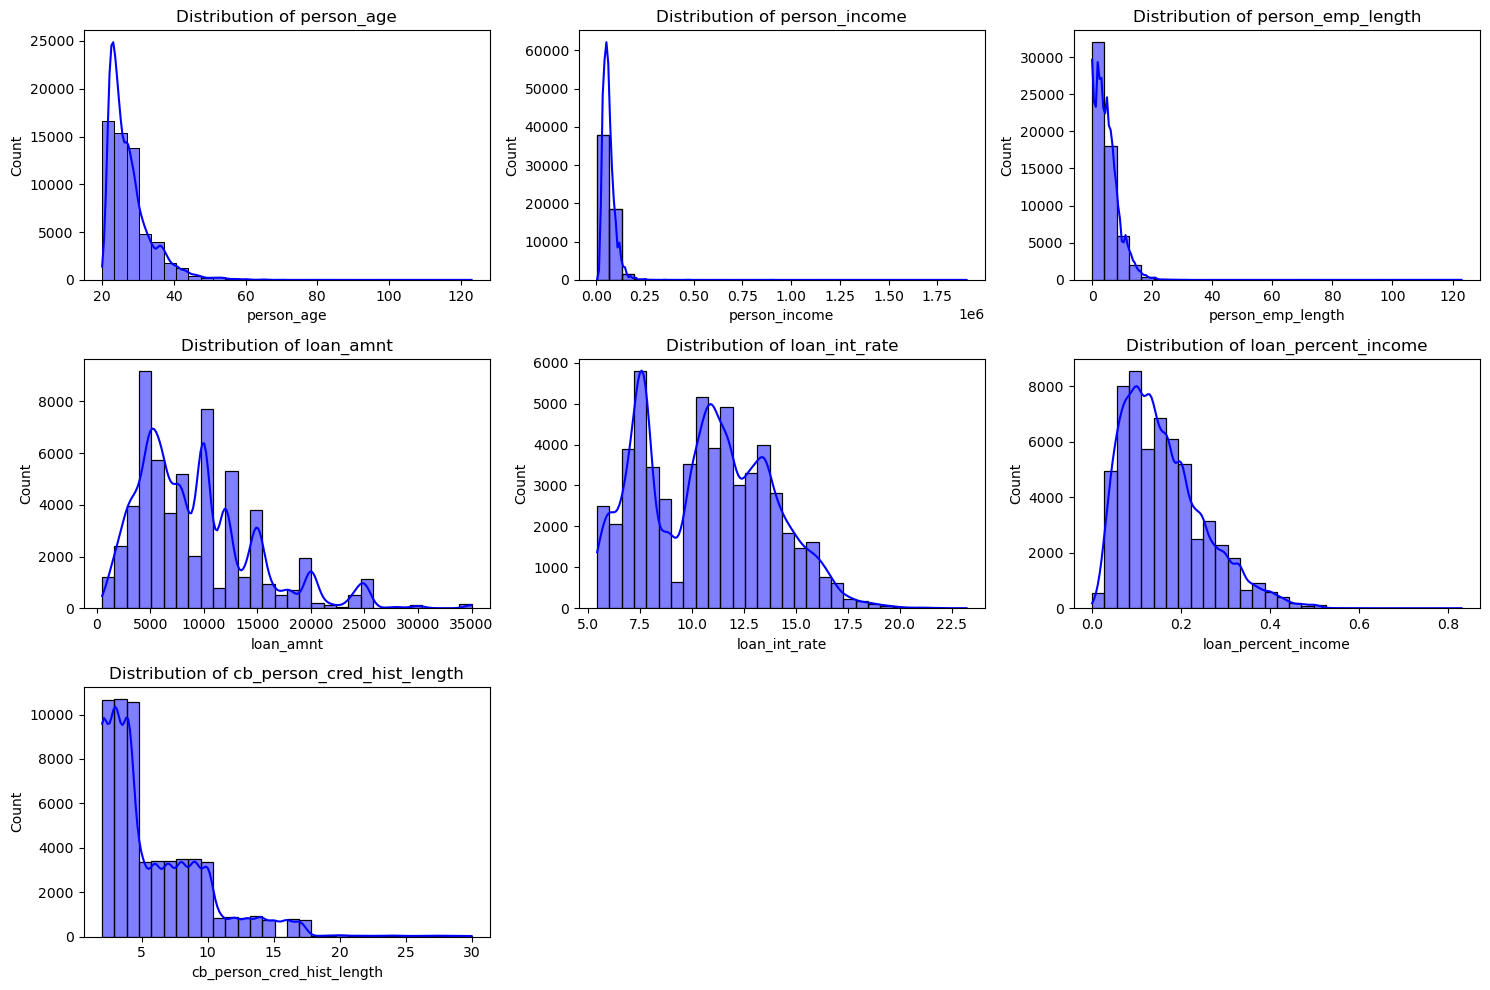

In [853]:
# Visualize distributions of numerical columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot((len(numerical_cols) // 3) + 1, 3, i)
    sns.histplot(df_train[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

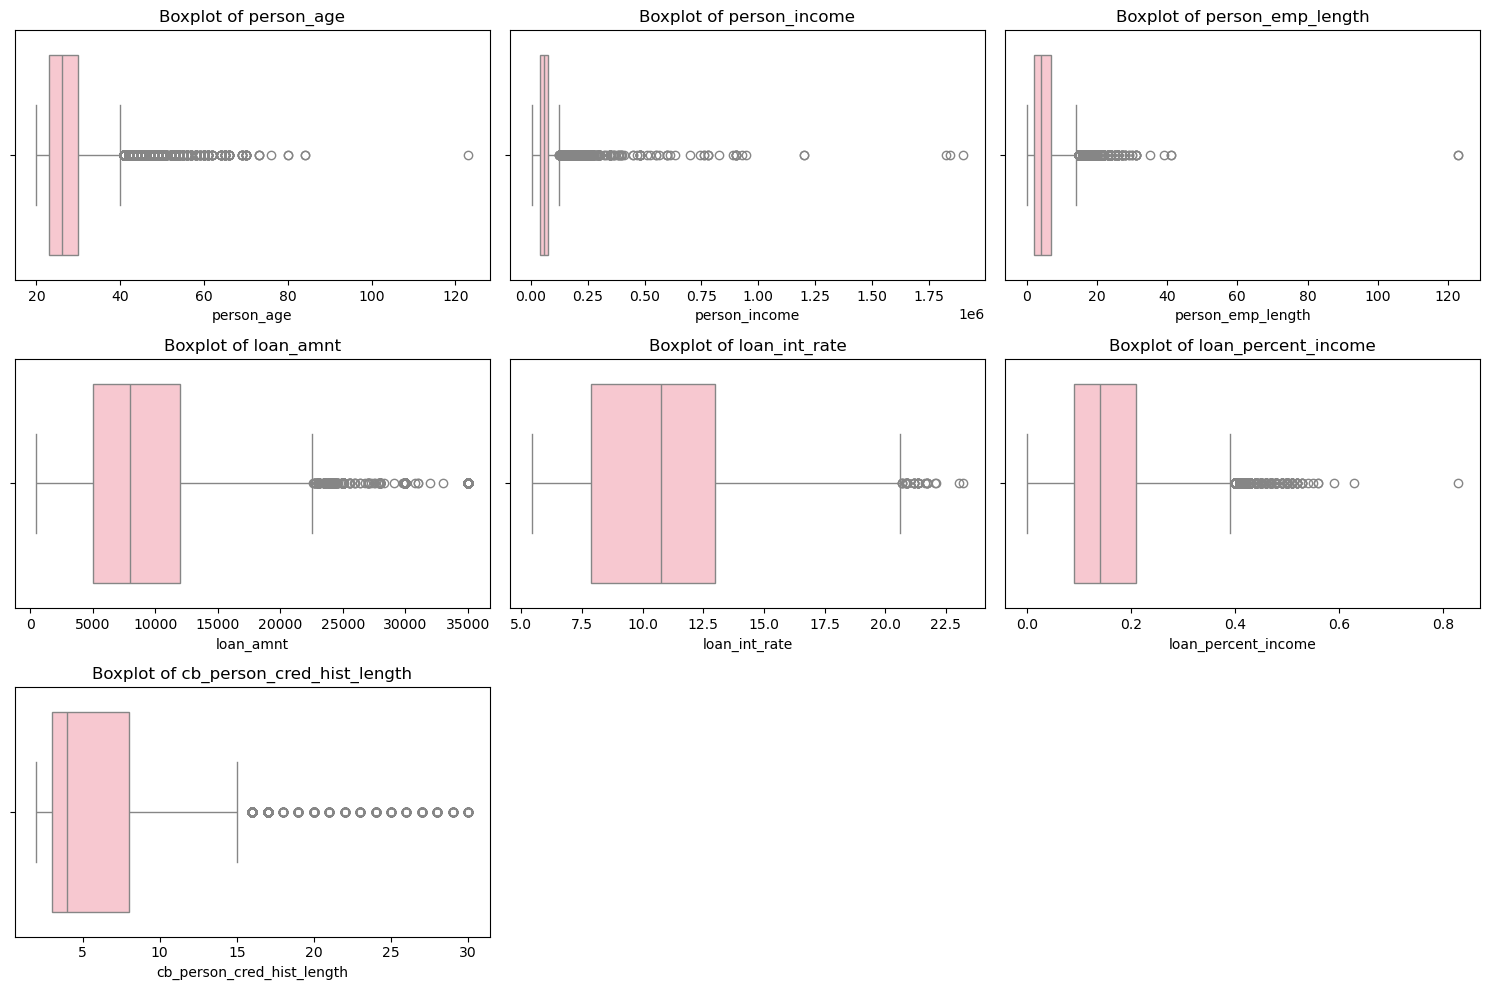

In [854]:
# Check for outliers using boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot((len(numerical_cols) // 3) + 1, 3, i)
    sns.boxplot(x=df_train[col], color='pink')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

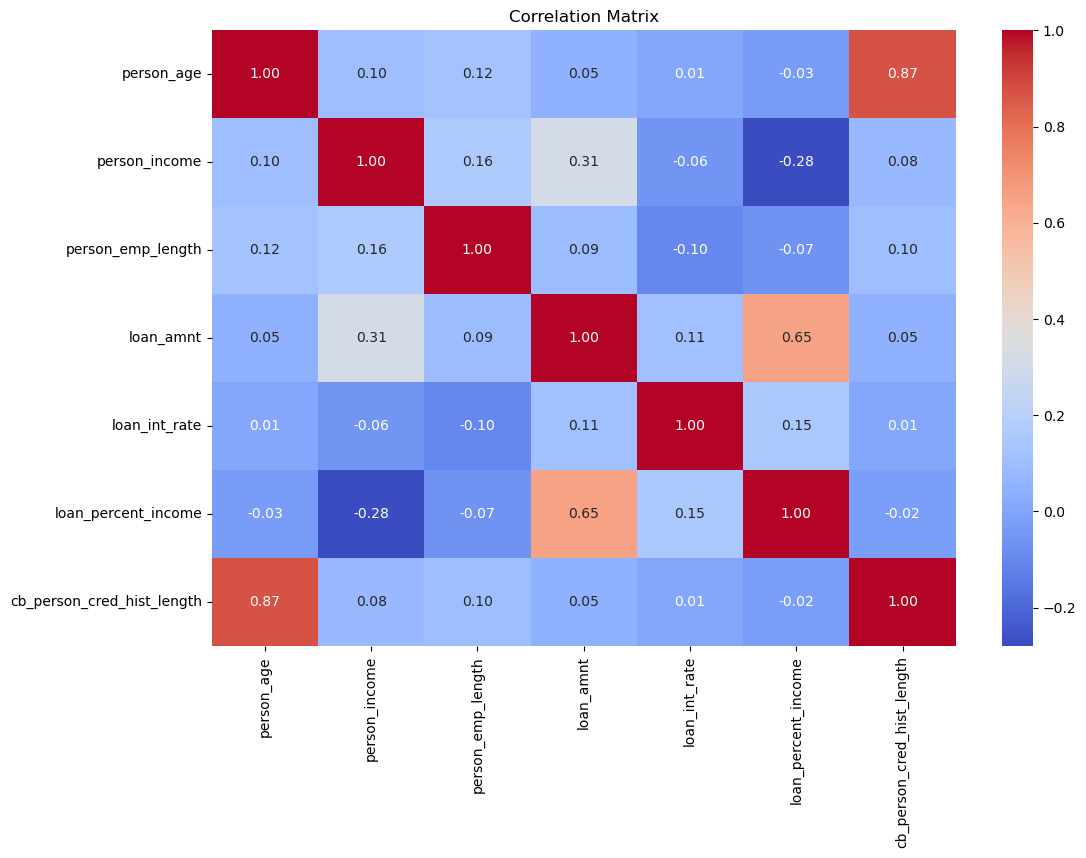

In [855]:
# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df_train[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

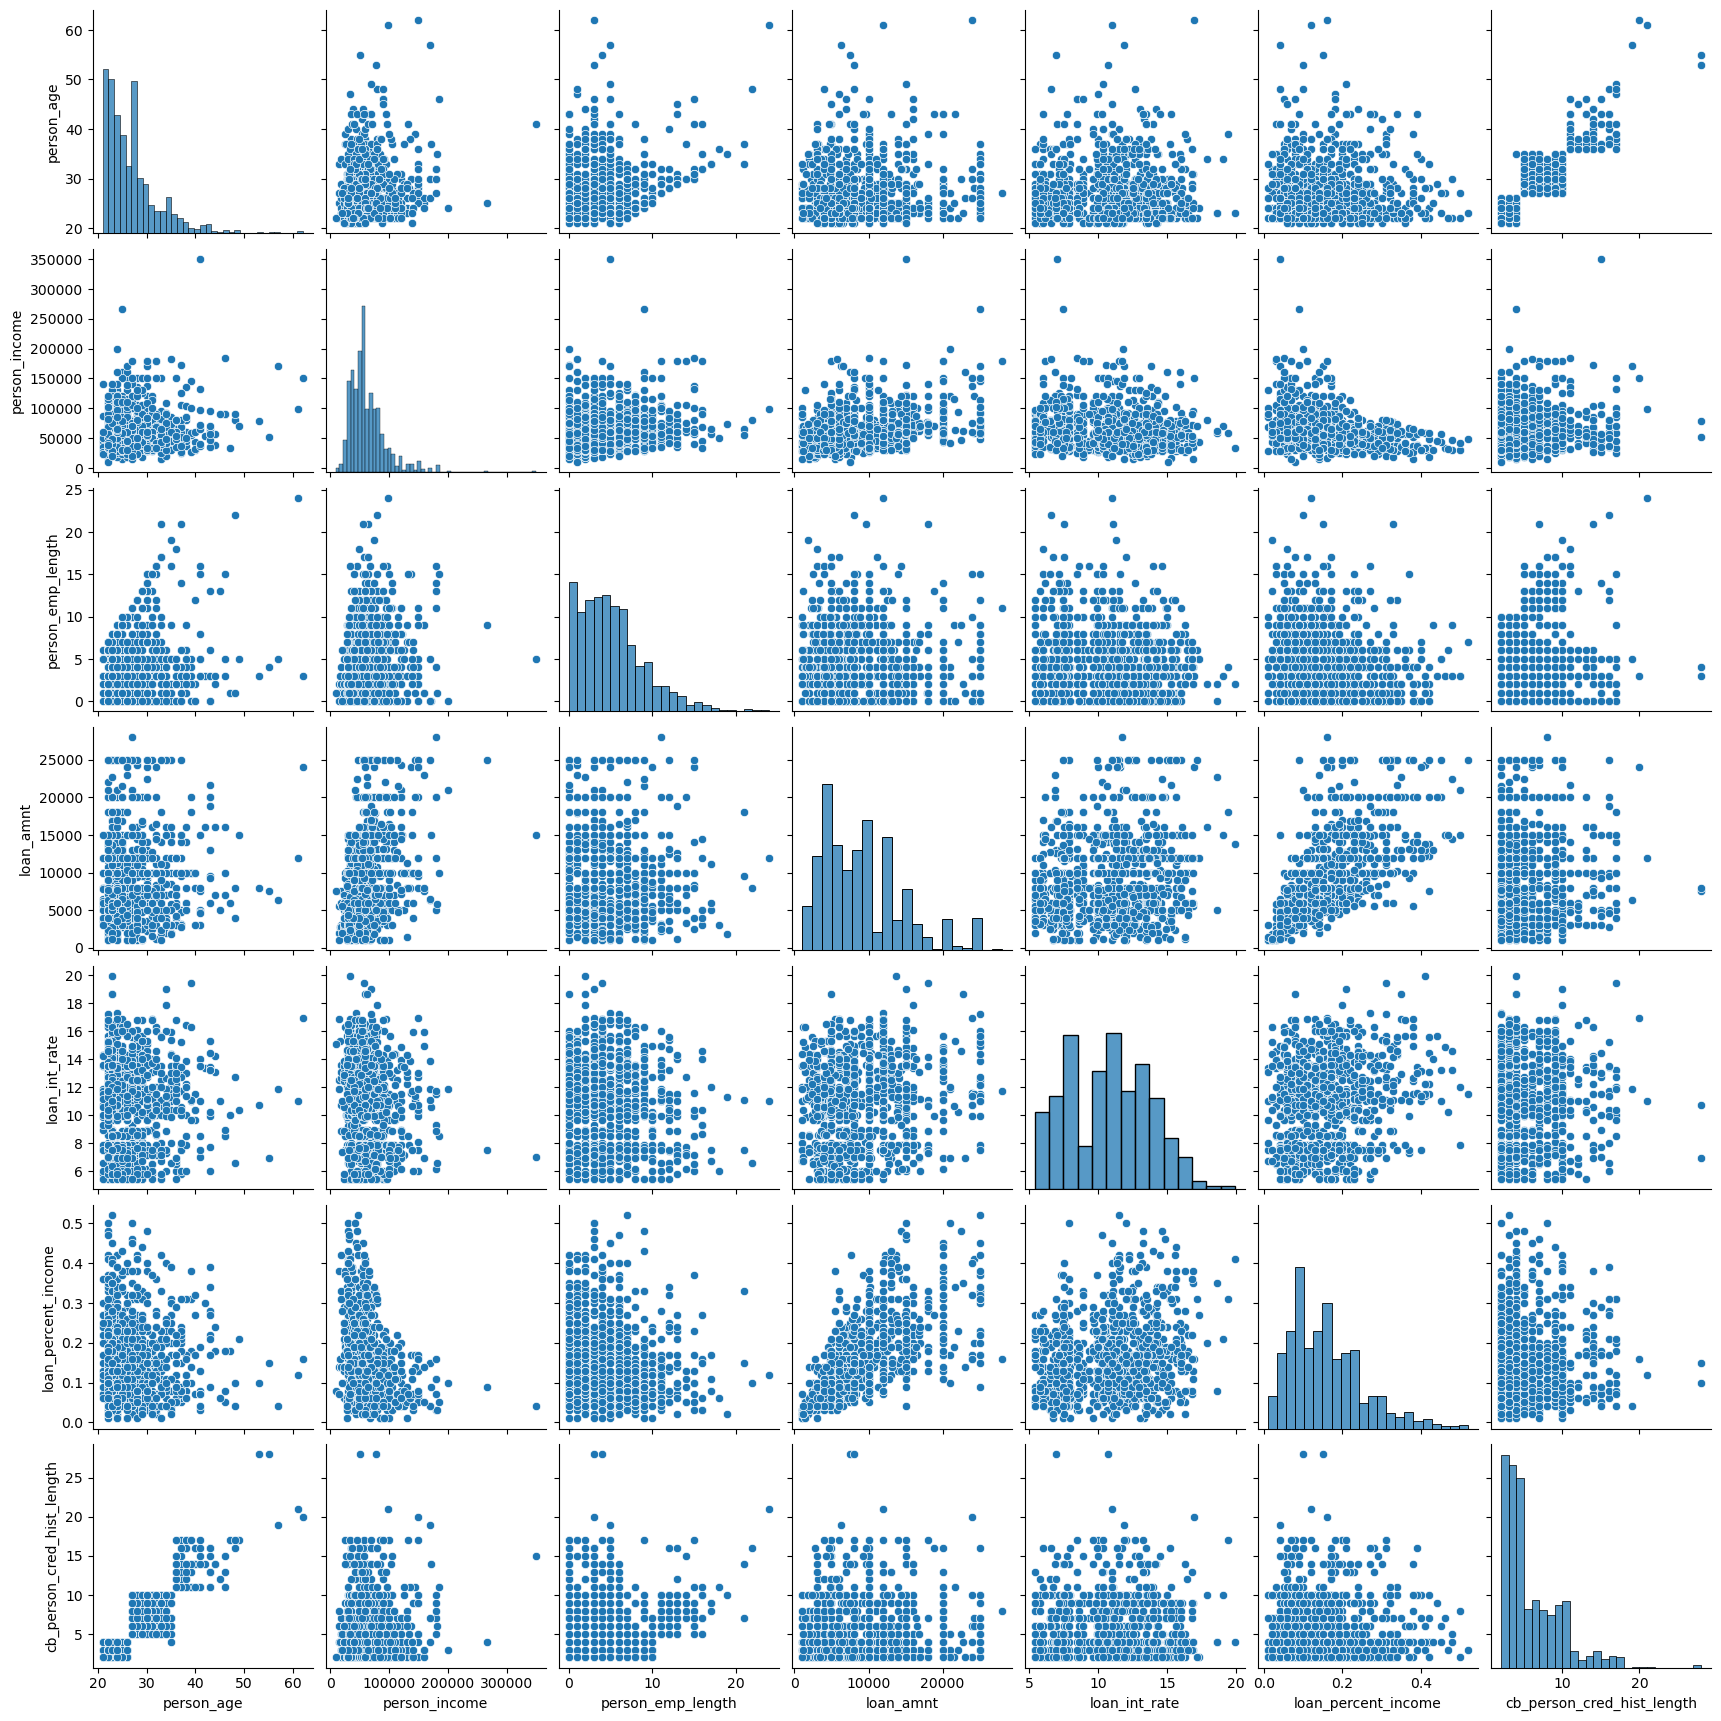

In [856]:
# Pairplot for relationships between features
sns.pairplot(df_train[numerical_cols].sample(min(len(df_train), 1000)))  # Sample for visualization if the dataset is large
plt.show()

In [857]:
# Insights from skewness
print("\nSkewness of Train Data Numerical Columns:\n")
print(df_train[numerical_cols].skew())


Skewness of Train Data Numerical Columns:

person_age                     1.965497
person_income                 10.457723
person_emp_length              2.054430
loan_amnt                      1.188578
loan_int_rate                  0.200020
loan_percent_income            0.917473
cb_person_cred_hist_length     1.618503
dtype: float64


In [858]:
# Insights from skewness
print("\nSkewness of Train Data Numerical Columns:\n")
print(df_test[numerical_cols].skew())


Skewness of Train Data Numerical Columns:

person_age                     1.942489
person_income                 10.446480
person_emp_length              1.163814
loan_amnt                      1.204413
loan_int_rate                  0.185347
loan_percent_income            0.939094
cb_person_cred_hist_length     1.654130
dtype: float64


In [859]:
print('Training Data shape before set_index :', df_train.shape)
print('Testing Data shape before set_index:', df_test.shape)

Training Data shape before set_index : (58645, 11)
Testing Data shape before set_index: (39098, 11)


In [860]:
import pandas as pd

# Assuming df_train is your train dataset and df_test is your test dataset

def identify_skewness(data):
    # Select only numerical columns
    numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

    skewness = data[numerical_cols].skew()  # Calculate skewness for each numerical column
    skewed_columns = {}

    for col in skewness.index:
        if skewness[col] > 1:
            skewed_columns[col] = "Right Skewed"
        elif skewness[col] < -1:
            skewed_columns[col] = "Left Skewed"
        else:
            skewed_columns[col] = "Normal"

    return skewed_columns

# Identify skewness for train dataset
skewness_train = identify_skewness(df_train)
print("Skewness for Train Dataset:")
for col, skew_type in skewness_train.items():
    print(f"{col}: {skew_type}")

# Identify skewness for test dataset
skewness_test = identify_skewness(df_test)
print("\nSkewness for Test Dataset:")
for col, skew_type in skewness_test.items():
    print(f"{col}: {skew_type}")


Skewness for Train Dataset:
person_age: Right Skewed
person_income: Right Skewed
person_emp_length: Right Skewed
loan_amnt: Right Skewed
loan_int_rate: Normal
loan_percent_income: Normal
cb_person_cred_hist_length: Right Skewed

Skewness for Test Dataset:
person_age: Right Skewed
person_income: Right Skewed
person_emp_length: Right Skewed
loan_amnt: Right Skewed
loan_int_rate: Normal
loan_percent_income: Normal
cb_person_cred_hist_length: Right Skewed


In [861]:
import pandas as pd

# Function to detect outliers using the IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Detect rows where values are outside the bounds
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Function to identify numerical columns needing outlier handling
def identify_outlier_columns(data):
    # Select only numerical columns
    numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
    
    outlier_columns = {}

    for col in numerical_cols:
        # Detect outliers using the IQR method
        outliers = detect_outliers_iqr(data, col)
        
        # If outliers exist, add the column to the outlier_columns dictionary
        if len(outliers) > 0:
            outlier_columns[col] = len(outliers)

    return outlier_columns

# Identify columns with outliers in the train dataset
outlier_columns_train = identify_outlier_columns(df_train)
print("Columns with Outliers in Train Dataset:")
for col, outlier_count in outlier_columns_train.items():
    print(f"{col}: {outlier_count} outliers")

# Identify columns with outliers in the test dataset
outlier_columns_test = identify_outlier_columns(df_test)
print("\nColumns with Outliers in Test Dataset:")
for col, outlier_count in outlier_columns_test.items():
    print(f"{col}: {outlier_count} outliers")


Columns with Outliers in Train Dataset:
person_age: 2446 outliers
person_income: 2411 outliers
person_emp_length: 1274 outliers
loan_amnt: 2045 outliers
loan_int_rate: 34 outliers
loan_percent_income: 1210 outliers
cb_person_cred_hist_length: 1993 outliers

Columns with Outliers in Test Dataset:
person_age: 1620 outliers
person_income: 1540 outliers
person_emp_length: 778 outliers
loan_amnt: 1388 outliers
loan_int_rate: 11 outliers
loan_percent_income: 811 outliers
cb_person_cred_hist_length: 1436 outliers


In [862]:
import pandas as pd
import numpy as np

# Function to calculate the number and percentage of outliers in a dataset
def calculate_outlier_stats(data, numerical_columns):
    outlier_stats = []
    
    for col in numerical_columns:
        # Calculate IQR
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count outliers
        num_outliers = ((data[col] < lower_bound) | (data[col] > upper_bound)).sum()
        total_values = len(data[col])
        
        # Calculate percentage
        outlier_percentage = (num_outliers / total_values) * 100
        
        # Append results to list
        outlier_stats.append([col, num_outliers, round(outlier_percentage,2)])
    
    # Convert to DataFrame
    outlier_df = pd.DataFrame(outlier_stats, columns=["Feature", "Number of Outliers", "Percentage of Outliers"])
    return outlier_df

# Define the numerical columns in your dataset
numerical_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 
                  'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

# Calculate outlier stats for train and test datasets
train_outlier_df = calculate_outlier_stats(df_train, numerical_cols)
test_outlier_df = calculate_outlier_stats(df_test, numerical_cols)

# Display the results
print("\nOutlier Summary for Train Dataset:")
print(train_outlier_df)

print("\nOutlier Summary for Test Dataset:")
print(test_outlier_df)



Outlier Summary for Train Dataset:
                      Feature  Number of Outliers  Percentage of Outliers
0                  person_age                2446                    4.17
1               person_income                2411                    4.11
2           person_emp_length                1274                    2.17
3                   loan_amnt                2045                    3.49
4               loan_int_rate                  34                    0.06
5         loan_percent_income                1210                    2.06
6  cb_person_cred_hist_length                1993                    3.40

Outlier Summary for Test Dataset:
                      Feature  Number of Outliers  Percentage of Outliers
0                  person_age                1620                    4.14
1               person_income                1540                    3.94
2           person_emp_length                 778                    1.99
3                   loan_amnt            

In [863]:
train_outlier_df

,Feature,Number of Outliers,Percentage of Outliers
0,person_age,2446,4.17
1,person_income,2411,4.11
2,person_emp_length,1274,2.17
3,loan_amnt,2045,3.49
4,loan_int_rate,34,0.06
5,loan_percent_income,1210,2.06
6,cb_person_cred_hist_length,1993,3.40


In [864]:
test_outlier_df

,Feature,Number of Outliers,Percentage of Outliers
0,person_age,1620,4.14
1,person_income,1540,3.94
2,person_emp_length,778,1.99
3,loan_amnt,1388,3.55
4,loan_int_rate,11,0.03
5,loan_percent_income,811,2.07
6,cb_person_cred_hist_length,1436,3.67


In [865]:
#Handling outliers in columns that are more than 2% 

outlier_cols = ["person_age", "person_income", "cb_person_cred_hist_length", "loan_amnt"]


# Detecting Outlier Data in Training Data

In [867]:
# Function to identify outliers using the IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Detect outliers in each numerical column
outliers = {}
for col in numerical_cols:
    outliers[col] = detect_outliers_iqr(df_train, col)

# Print summary of outliers
print("\nOutliers Summary:")
for col, rows in outliers.items():
    print(f"- {col}: {len(rows)} outliers")


Outliers Summary:
- person_age: 2446 outliers
- person_income: 2411 outliers
- person_emp_length: 1274 outliers
- loan_amnt: 2045 outliers
- loan_int_rate: 34 outliers
- loan_percent_income: 1210 outliers
- cb_person_cred_hist_length: 1993 outliers


In [868]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Detect outliers in each numerical column
outliers = {}
for col in numerical_cols:
    outliers[col] = detect_outliers_iqr(df_test, col)

# Print summary of outliers
print("\nOutliers Summary:")
for col, rows in outliers.items():
    print(f"- {col}: {len(rows)} outliers")


Outliers Summary:
- person_age: 1620 outliers
- person_income: 1540 outliers
- person_emp_length: 778 outliers
- loan_amnt: 1388 outliers
- loan_int_rate: 11 outliers
- loan_percent_income: 811 outliers
- cb_person_cred_hist_length: 1436 outliers


# Handling Outlier Data in Training Data

# Handling outliers by clipping (replacing with upper/lower bounds)
def clip_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[column] = np.clip(data[column], lower_bound, upper_bound)

# Apply clipping to handle outliers
for col in outlier_cols:
    clip_outliers(df_train, col)

print("\nOutliers have been clipped to the IQR range.")

In [909]:
# Outlier capping using IQR
def cap_outliers_iqr(data, column, lower_bound, upper_bound):
    data[column] = np.clip(data[column], lower_bound, upper_bound)

# Calculate IQR bounds for train dataset
iqr_bounds = {}
for col in df_train.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    iqr_bounds[col] = (lower_bound, upper_bound)
    # Apply capping for train data
    cap_outliers_iqr(df_train, col, lower_bound, upper_bound)

# Apply the same bounds to the test dataset
for col, (lower_bound, upper_bound) in iqr_bounds.items():
    cap_outliers_iqr(df_test[outlier_cols], col, lower_bound, upper_bound)

C:\Users\monas\AppData\Local\Temp\ipykernel_34444\691789223.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = np.clip(data[column], lower_bound, upper_bound)
C:\Users\monas\AppData\Local\Temp\ipykernel_34444\691789223.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = np.clip(data[column], lower_bound, upper_bound)


KeyError: 'person_emp_length'

In [807]:
print('Training Data shape before set_index :', df_train.shape)
print('Testing Data shape before set_index:', df_test.shape)

Training Data shape before set_index : (58645, 11)
Testing Data shape before set_index: (39098, 11)


In [809]:
# Checking for skewness
print("\nSkewness of Train Data Numerical Columns\nAfter Outlier Handling:\n")
print(df_train[numerical_cols].skew())


Skewness of Train Data Numerical Columns
After Outlier Handling:

person_age                    1.070064
person_income                 0.783787
person_emp_length             0.809945
loan_amnt                     0.833442
loan_int_rate                 0.195841
loan_percent_income           0.748665
cb_person_cred_hist_length    1.097443
dtype: float64


# Using log transformation to address skewness

In [811]:
from scipy.stats import boxcox, yeojohnson

# Function to apply transformations based on skewness
def transform_skewed_columns(data, column, method="log"):
    if method == "log":
        data[column] = np.log1p(data[column])
    elif method == "boxcox":
        data[column], _ = boxcox(data[column] + 1e-6)  # Add small value to avoid zero errors
    elif method == "yeojohnson":
        data[column], _ = yeojohnson(data[column])

# Apply transformations to train and test datasets
for col in df_train.select_dtypes(include=['float64', 'int64']).columns:
    skewness = df_train[col].skew()
    if skewness > 1:  # Right skewed
        transform_skewed_columns(df_train, col, method="log")
        #transform_skewed_columns(df_test, col, method="log")
    elif 0.5 < skewness <= 1:  # Moderate skew
        transform_skewed_columns(df_train, col, method="boxcox")
        #transform_skewed_columns(df_test, col, method="boxcox")
    elif skewness < -1:  # Left skewed
        transform_skewed_columns(df_train, col, method="yeojohnson")
        #transform_skewed_columns(df_test, col, method="yeojohnson")


In [813]:
# Checking for skewness
print("\nSkewness of Train Data Numerical Columns\nAfter Log Transformation Handling:\n")
print(df_train[numerical_cols].skew())


Skewness of Train Data Numerical Columns
After Outlier Handling:

person_age                    0.783638
person_income                -0.007221
person_emp_length            -1.036135
loan_amnt                    -0.029809
loan_int_rate                 0.195841
loan_percent_income          -0.035492
cb_person_cred_hist_length    0.374689
dtype: float64


#Using log transformation to address skewness
df_train['person_age'] = np.log1p(df_train['person_age'])  # log(1 + x) avoids log(0)
df_train['person_emp_length'] = np.log1p(df_train['person_emp_length'])  
df_train['cb_person_cred_hist_length'] = np.log1p(df_train['cb_person_cred_hist_length'])

import numpy as np

# Function for log transformation (right-skewed)
def log_transform(data, column):
    data[column] = np.log1p(data[column])

# Function for square root transformation (right-skewed)
def sqrt_transform(data, column):
    data[column] = np.sqrt(data[column])

# Consistent Transformations (based on train data skewness)
log_transform(df_train, 'person_age')  # Train skewness > 1
#log_transform(df_test, 'person_age')  # Same transformation for test

sqrt_transform(df_train, 'person_emp_length')  # Train skewness > 2
#sqrt_transform(df_test, 'person_emp_length')  # Same transformation for test

log_transform(df_train, 'cb_person_cred_hist_length')  # Train skewness > 1
#log_transform(df_test, 'cb_person_cred_hist_length')  # Same transformation for test

# Optional: Apply square root transformations for moderately skewed features
sqrt_transform(df_train, 'loan_amnt')  # Moderate skew
#sqrt_transform(df_test, 'loan_amnt')  # Same transformation for test

sqrt_transform(df_train, 'person_income')  # Moderate skew
#sqrt_transform(df_test, 'person_income')  # Same transformation for test

# Check updated skewness
print("Updated Skewness of Train Data:")
#print(df_train[numerical_.skew())

#print("\nUpdated Skewness of Test Data:")
#print(df_test.skew())


In [457]:
# Check for skewness
print("\nSkewness of Train Data Numerical Columns\nAfter Applying Log Transformation :\n")
print(df_train[numerical_cols].skew())


Skewness of Train Data Numerical Columns
After Applying Log Transformation :

person_age                    0.783638
person_income                 0.355043
person_emp_length            -0.227678
loan_amnt                     0.228285
loan_int_rate                 0.200020
loan_percent_income           0.917473
cb_person_cred_hist_length    0.374689
dtype: float64


# Visualising The Train Numerical Data After Outlier Handling

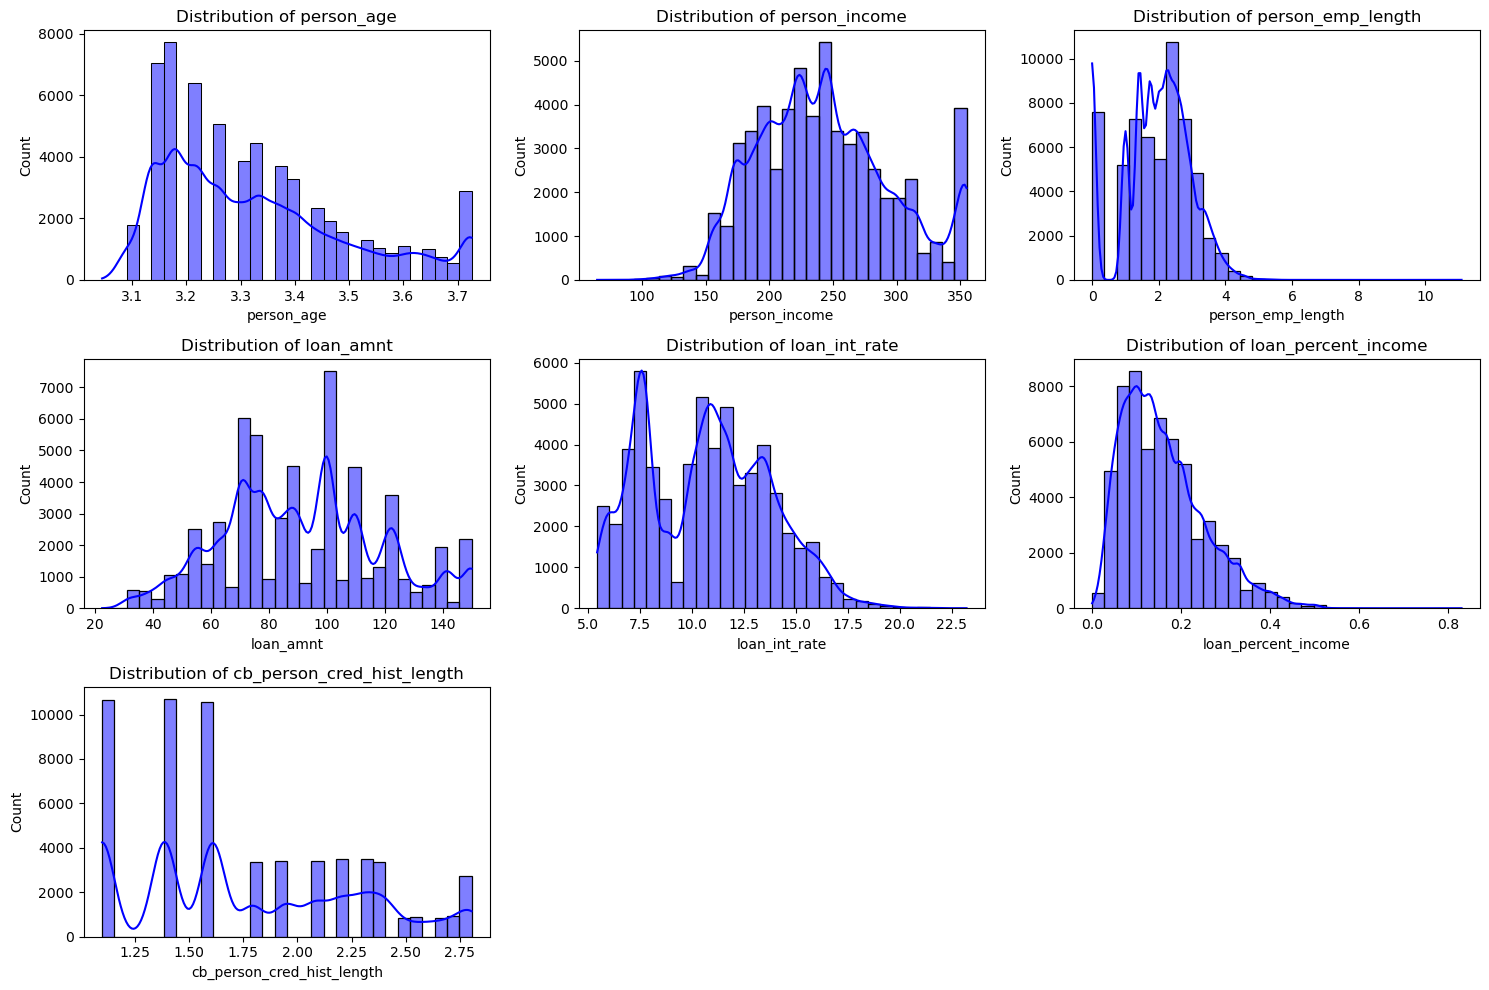

In [459]:
# Visualize distributions of numerical columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot((len(numerical_cols) // 3) + 1, 3, i)
    sns.histplot(df_train[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()


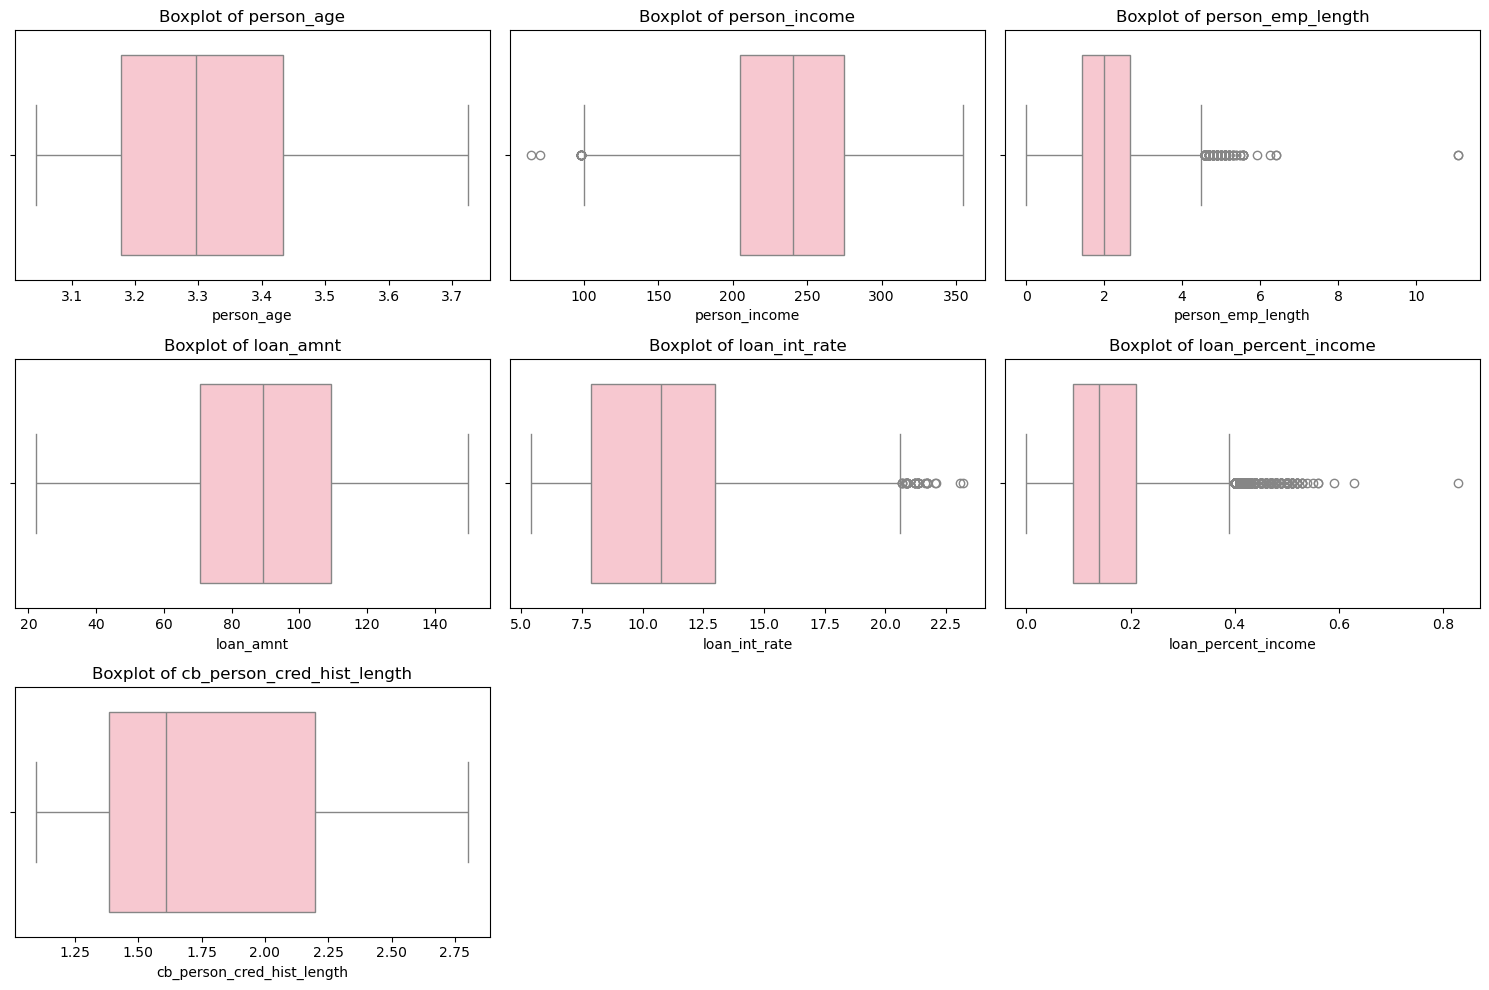

In [460]:
# Check for outliers using boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot((len(numerical_cols) // 3) + 1, 3, i)
    sns.boxplot(x=df_train[col], color='pink')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

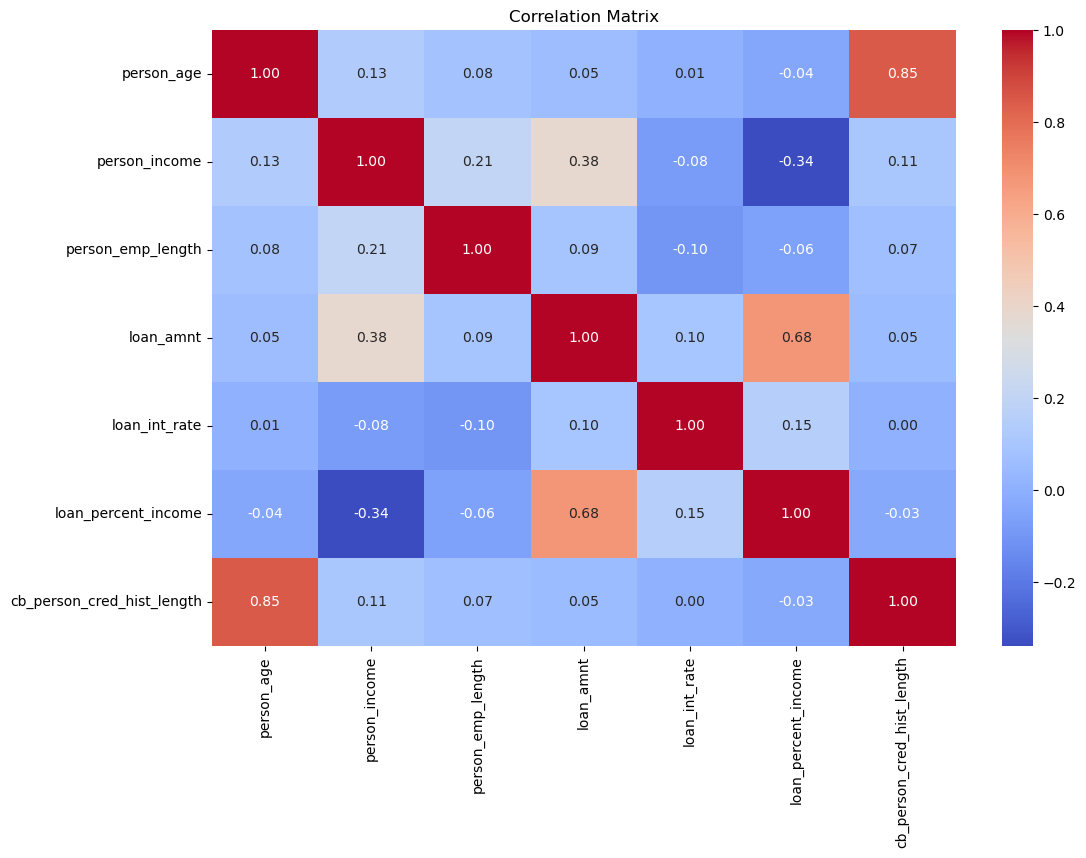

In [461]:
# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df_train[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Test Numerical Data Visualization

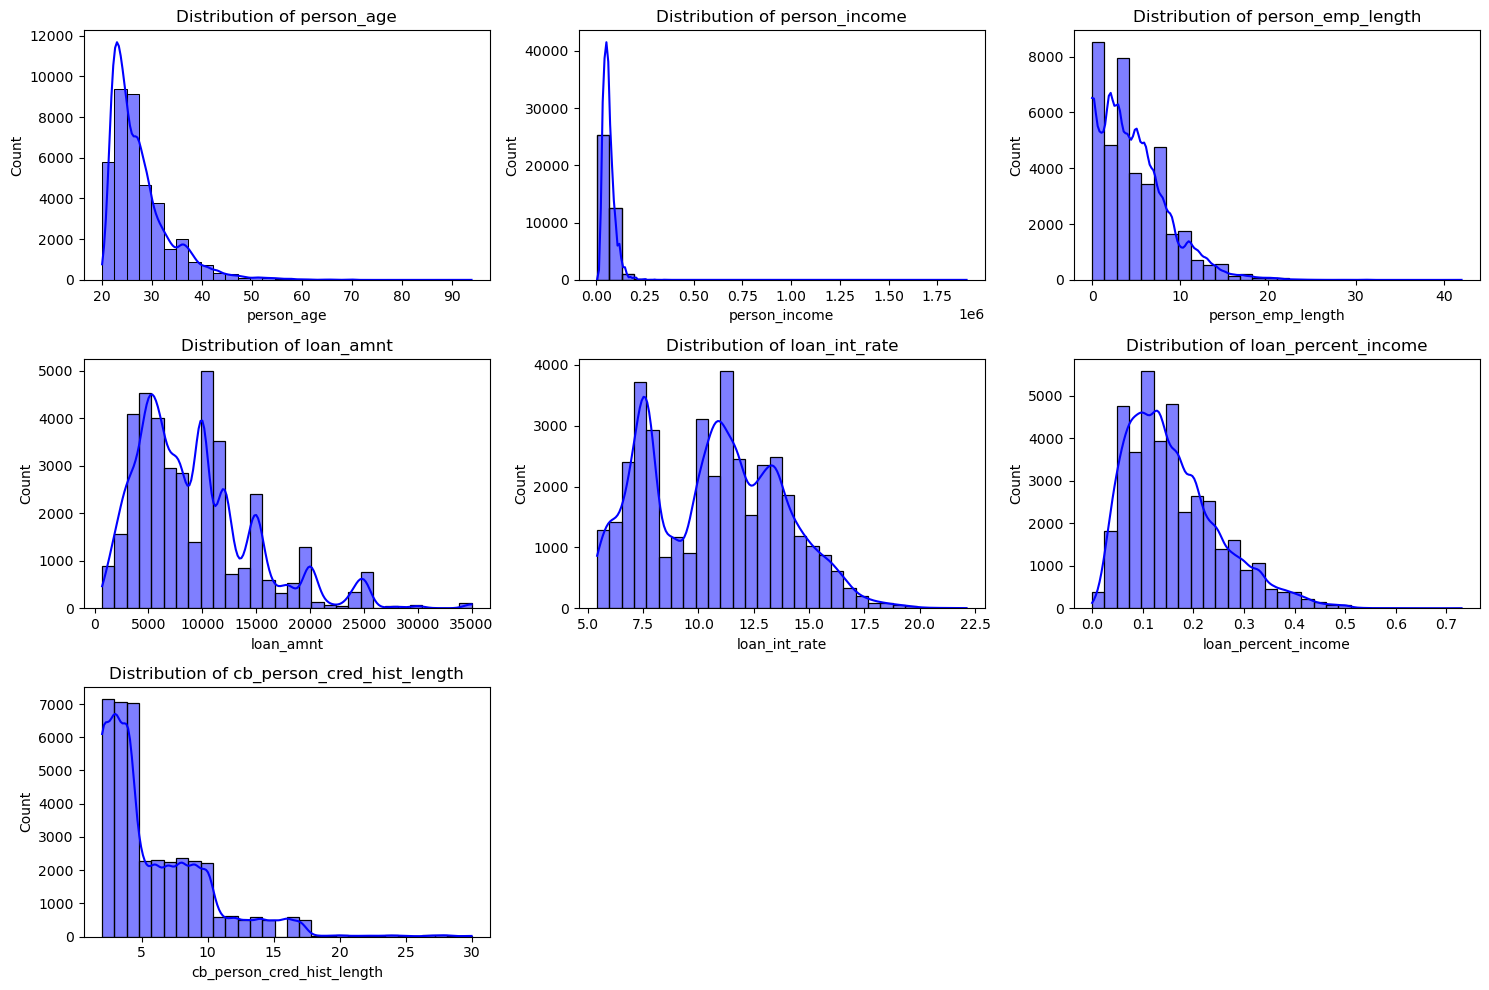

In [463]:
# Visualize distributions of numerical columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot((len(numerical_cols) // 3) + 1, 3, i)
    sns.histplot(df_test[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

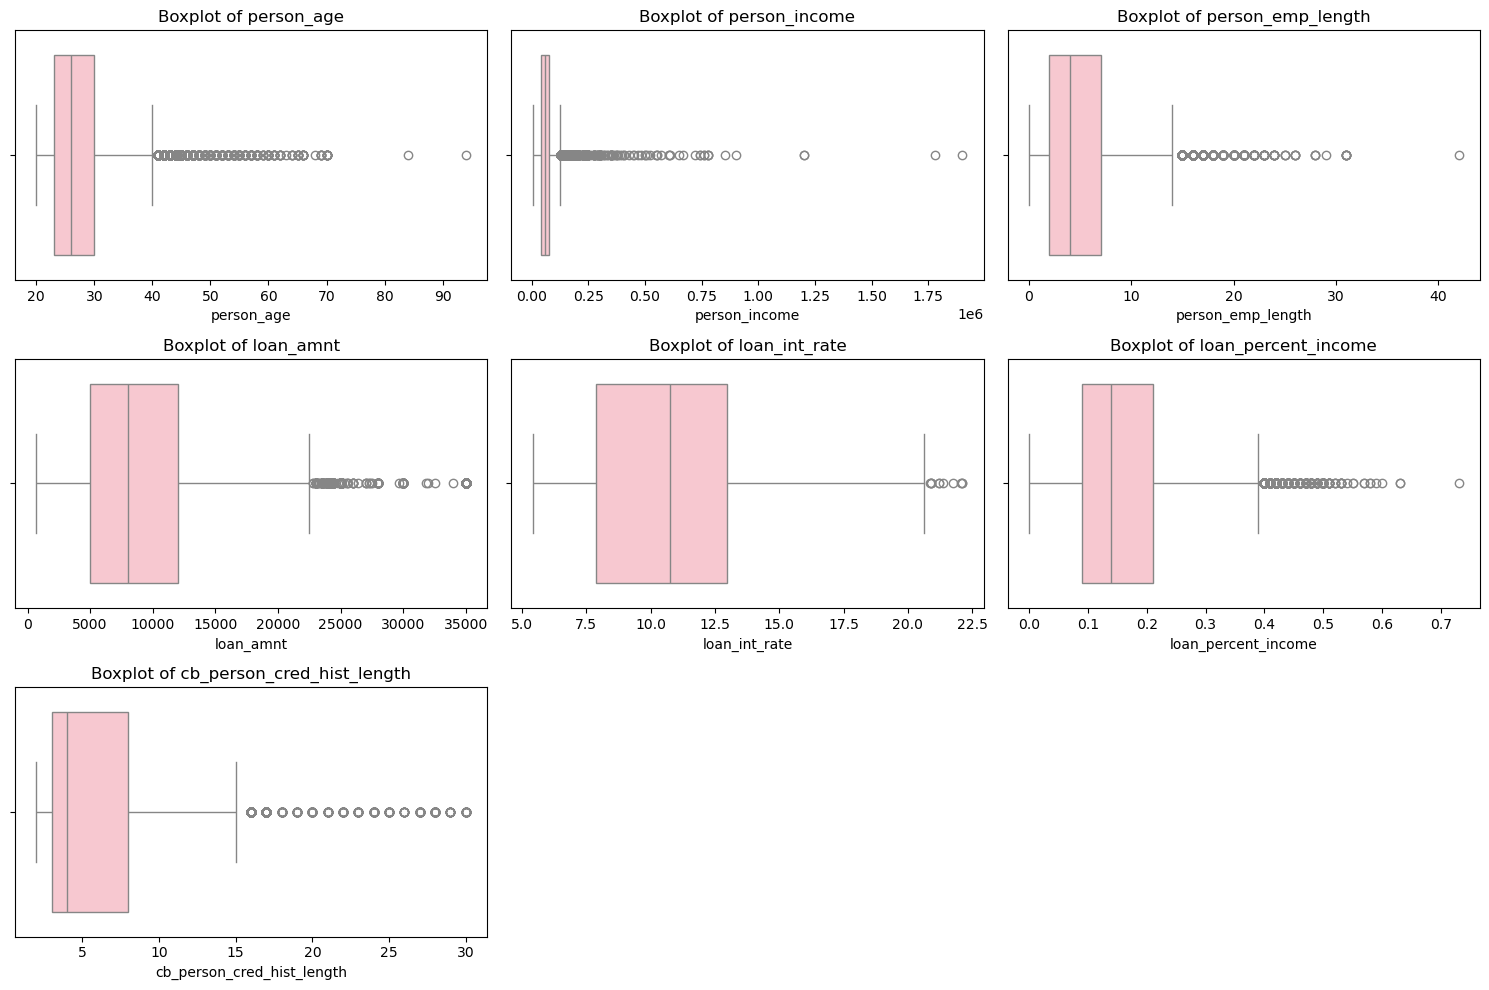

In [464]:
# Check for outliers using boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot((len(numerical_cols) // 3) + 1, 3, i)
    sns.boxplot(x=df_test[col], color='pink')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

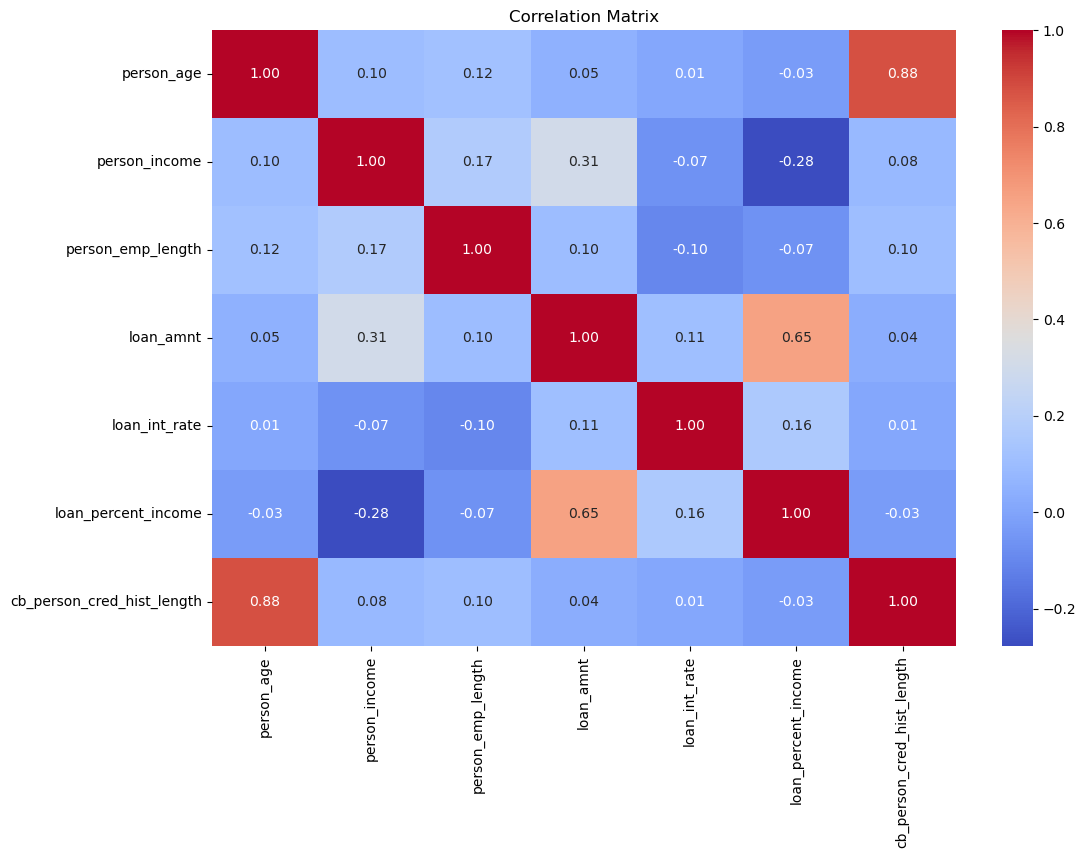

In [465]:
# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df_test[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [515]:
# Insights from skewness
print("\nSkewness of Test Data Numerical Columns:\n")
print(df_test[numerical_cols].skew())


Skewness of Test Data Numerical Columns:

person_age                     1.942489
person_income                 10.446480
person_emp_length              1.163814
loan_amnt                      1.204413
loan_int_rate                  0.185347
loan_percent_income            0.939094
cb_person_cred_hist_length     1.654130
dtype: float64


In [517]:
# Function to identify outliers using the IQR method (same as in df_train)
def detect_outliers_iqr(data, column, lower_bound, upper_bound):
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Function to clip outliers using the IQR method (same as in df_train)
#def clip_outliers(data, column, lower_bound, upper_bound):
#    data[column] = np.clip(data[column], lower_bound, upper_bound)

# Calculate the IQR, lower and upper bounds for each numerical column based on df_train
outlier_bounds_test = {}
for col in numerical_cols:
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_bounds_test[col] = (lower_bound, upper_bound)

# Detect outliers in df_test using the bounds calculated from df_train
outliers_test = {}
for col in numerical_cols:
    lower_bound, upper_bound = outlier_bounds_test[col]
    outliers_test[col] = detect_outliers_iqr(df_test, col, lower_bound, upper_bound)

# Print summary of outliers in df_test
print("\nOutliers Summary in Test Data:")
for col, rows in outliers_test.items():
    print(f"- {col}: {len(rows)} outliers")

# Apply clipping to handle outliers in df_test
#for col in outlier_cols:
#    lower_bound, upper_bound = outlier_bounds_test[col]
#    clip_outliers(df_test, col, lower_bound, upper_bound)


print("\nOutliers in test data have been clipped to the IQR range.")



Outliers Summary in Test Data:
- person_age: 39098 outliers
- person_income: 39098 outliers
- person_emp_length: 17822 outliers
- loan_amnt: 39098 outliers
- loan_int_rate: 11 outliers
- loan_percent_income: 811 outliers
- cb_person_cred_hist_length: 24886 outliers

Outliers in test data have been clipped to the IQR range.


In [519]:
# Insights from skewness
print("\nSkewness of Test Data Numerical Columns:\nAfter Outlier Handling\n")
print(df_test[numerical_cols].skew())


Skewness of Test Data Numerical Columns:
After Outlier Handling

person_age                    0.000000
person_income                 0.000000
person_emp_length             1.163814
loan_amnt                     0.000000
loan_int_rate                 0.185347
loan_percent_income           0.939094
cb_person_cred_hist_length   -1.358899
dtype: float64


In [521]:
import numpy as np

# Function for log transformation (right-skewed)
def log_transform(data, column):
    data[column] = np.log1p(data[column])

# Function for square root transformation (right-skewed)
def sqrt_transform(data, column):
    data[column] = np.sqrt(data[column])

# Consistent Transformations (based on train data skewness)
#log_transform(df_train, 'person_age')  # Train skewness > 1
#log_transform(df_test, 'person_age')  # Same transformation for test

#sqrt_transform(df_train, 'person_emp_length')  # Train skewness > 2
sqrt_transform(df_test, 'person_emp_length')  # Same transformation for test

#log_transform(df_train, 'cb_person_cred_hist_length')  # Train skewness > 1
log_transform(df_test, 'cb_person_cred_hist_length')  # Same transformation for test

# Optional: Apply square root transformations for moderately skewed features
#sqrt_transform(df_train, 'loan_amnt')  # Moderate skew
#sqrt_transform(df_test, 'loan_amnt')  # Same transformation for test

#sqrt_transform(df_train, 'person_income')  # Moderate skew
#sqrt_transform(df_test, 'person_income')  # Same transformation for test

# Check updated skewness
print("Updated Skewness of Train Data:")
#print(df_train.skew())

#print("\nUpdated Skewness of Test Data:")
#print(df_test.skew())


Updated Skewness of Train Data:


In [523]:
# Insights from skewness
print("\nSkewness of Test Data Numerical Columns:\nAfter Outlier Handling\n")
print(df_test[numerical_cols].skew())


Skewness of Test Data Numerical Columns:
After Outlier Handling

person_age                    0.000000
person_income                 0.000000
person_emp_length            -0.270322
loan_amnt                     0.000000
loan_int_rate                 0.185347
loan_percent_income           0.939094
cb_person_cred_hist_length   -1.420558
dtype: float64


In [716]:
# Inverse transformation
df_test['cb_person_cred_hist_length'] = np.log1p(-df_test['cb_person_cred_hist_length'])

C:\Users\monas\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [722]:
df_test['person_age'].nunique()

1

In [724]:
df_test['person_age'].head()

id
58645    3.817887
58646    3.817887
58647    3.817887
58648    3.817887
58649    3.817887
Name: person_age, dtype: float64

In [718]:
# Insights from skewness
print("\nSkewness of Test Data Numerical Columns:\nAfter Outlier Handling\n")
print(df_test[numerical_cols].skew())


Skewness of Test Data Numerical Columns:
After Outlier Handling

person_age                    0.000000
person_income                 0.783589
person_emp_length             0.788152
loan_amnt                     0.830588
loan_int_rate                 0.183172
loan_percent_income           0.759930
cb_person_cred_hist_length         NaN
dtype: float64


In [561]:
# Function to clip using train boundaries
def clip_test_outliers(data, column, lower_bound, upper_bound):
    data[column] = np.clip(data[column], lower_bound, upper_bound)

# Applying train IQR bounds to the test dataset
for col in numerical_cols:
    Q1_train = df_train[col].quantile(0.25)
    Q3_train = df_train[col].quantile(0.75)
    IQR_train = Q3_train - Q1_train
    lower_bound_train = Q1_train - 1.5 * IQR_train
    upper_bound_train = Q3_train + 1.5 * IQR_train
    clip_test_outliers(df_test, col, lower_bound_train, upper_bound_train)

print("Test dataset outliers have been clipped using train dataset boundaries.")


Test dataset outliers have been clipped using train dataset boundaries.


In [604]:
# Insights from skewness
print("\nSkewness of Test Data Numerical Columns:\nAfter Outlier Handling\n")
print(df_test[numerical_cols].skew())


Skewness of Test Data Numerical Columns:
After Outlier Handling

person_age                    0.000000
person_income                 0.783589
person_emp_length             0.788152
loan_amnt                     0.830588
loan_int_rate                 0.183172
loan_percent_income           0.759930
cb_person_cred_hist_length   -1.358899
dtype: float64


df_test['cb_person_cred_hist_length'] = df_test['cb_person_cred_hist_length'].apply(lambda x: np.log(x + 1))  # To avoid issues with zero values

In [606]:
df_test['person_age'] = np.log1p(df_test['person_age'])
df_test['cb_person_cred_hist_length'] = np.log1p(df_test['cb_person_cred_hist_length'])

In [608]:
# Insights from skewness
print("\nSkewness of Test Data Numerical Columns:\nAfter Outlier Handling\n")
print(df_test[numerical_cols].skew())


Skewness of Test Data Numerical Columns:
After Outlier Handling

person_age                    0.000000
person_income                 0.783589
person_emp_length             0.788152
loan_amnt                     0.830588
loan_int_rate                 0.183172
loan_percent_income           0.759930
cb_person_cred_hist_length   -1.420558
dtype: float64


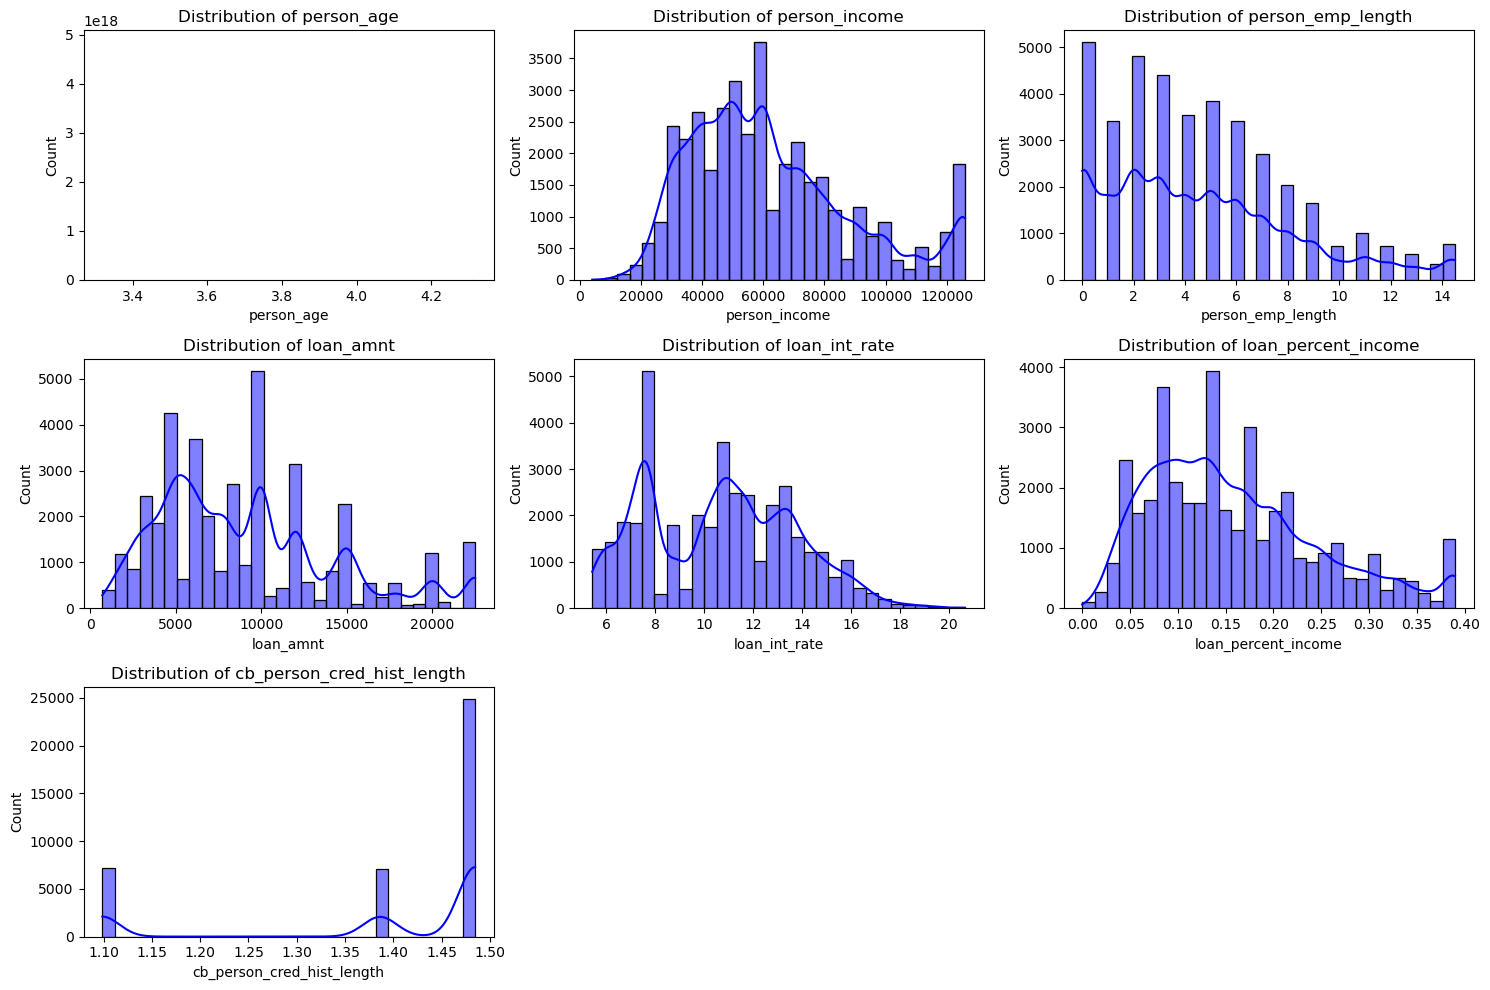

In [610]:
# Visualize distributions of numerical columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot((len(numerical_cols) // 3) + 1, 3, i)
    sns.histplot(df_test[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

# Applying train scaler to the test dataset
from sklearn.preprocessing import RobustScaler

# Fit the scaler on train data and transform test data
scaler = RobustScaler()
scaler.fit(df_train[numerical_cols])  # Fit on train data
df_test_scaled = pd.DataFrame(scaler.transform(df_test[numerical_cols]), columns=numerical_cols)

print("Test dataset numerical columns have been scaled using train dataset scaler.")


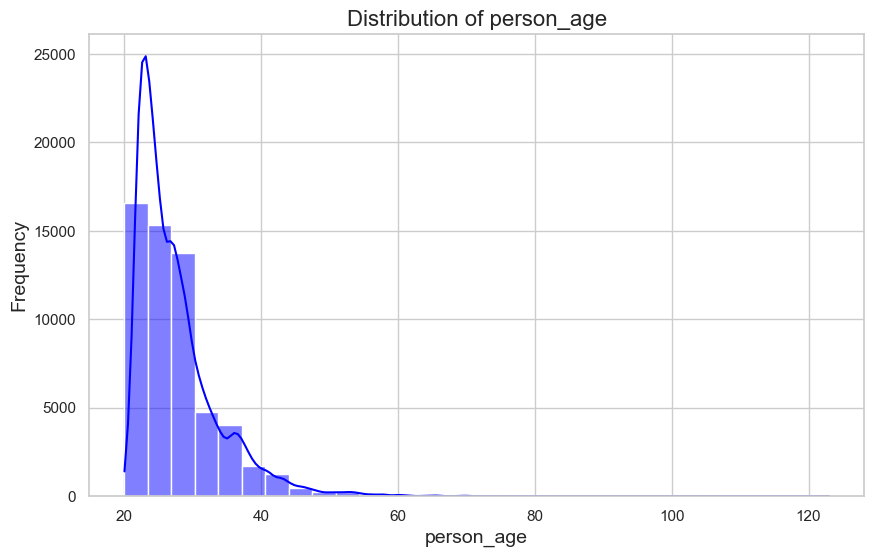

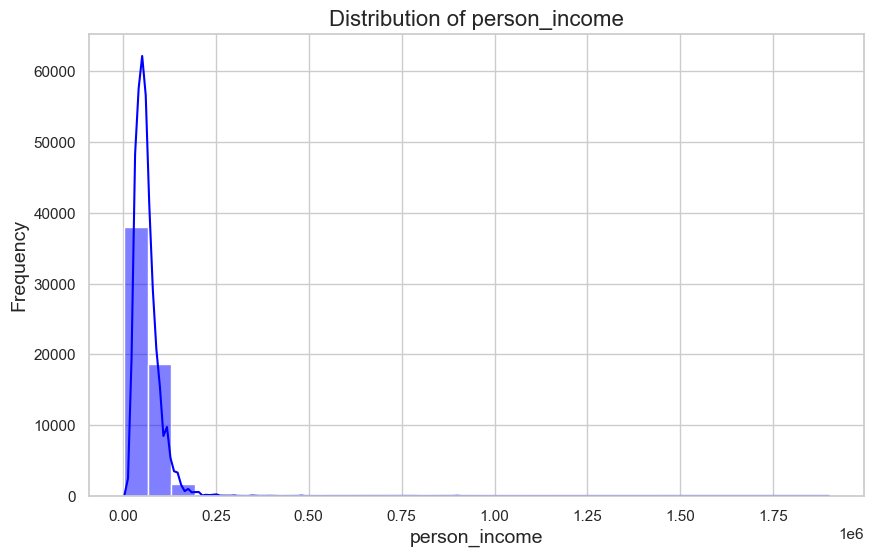

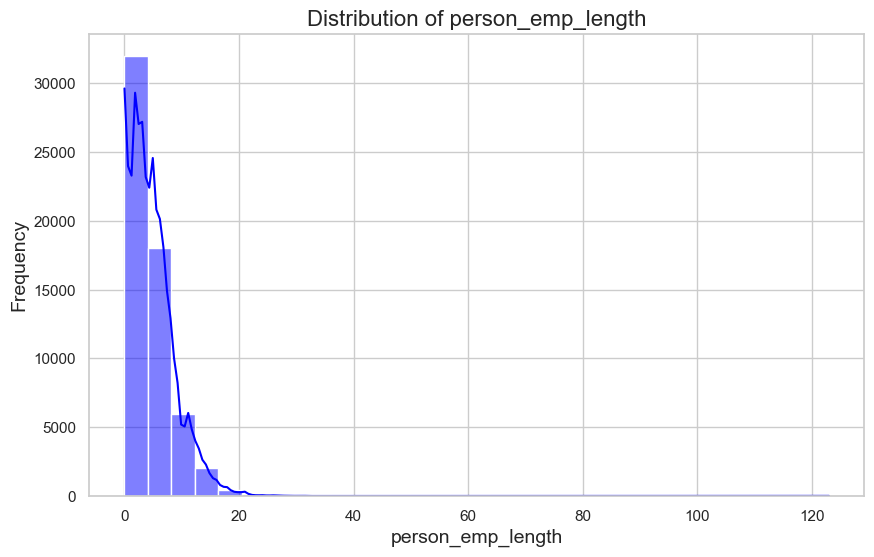

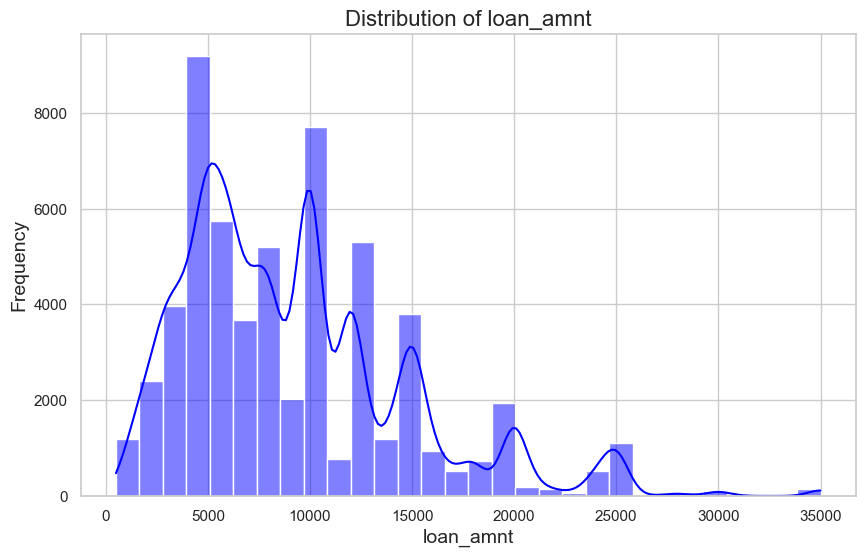

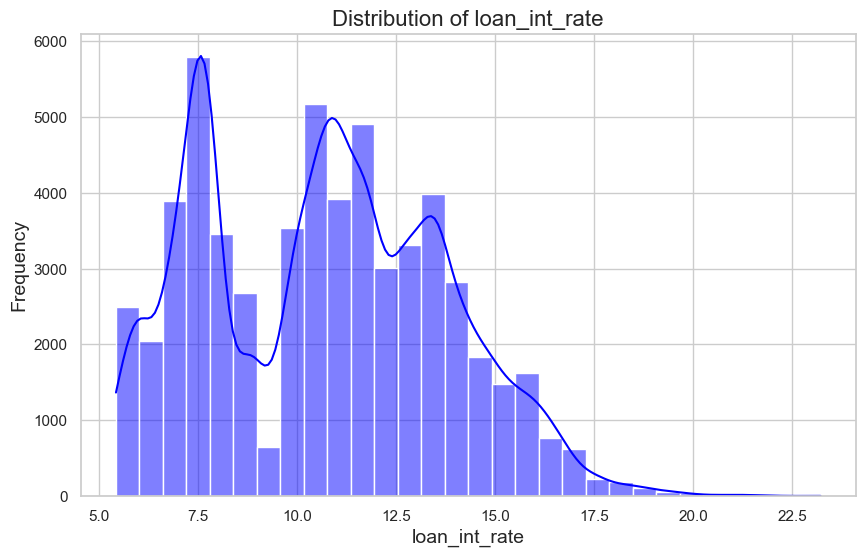

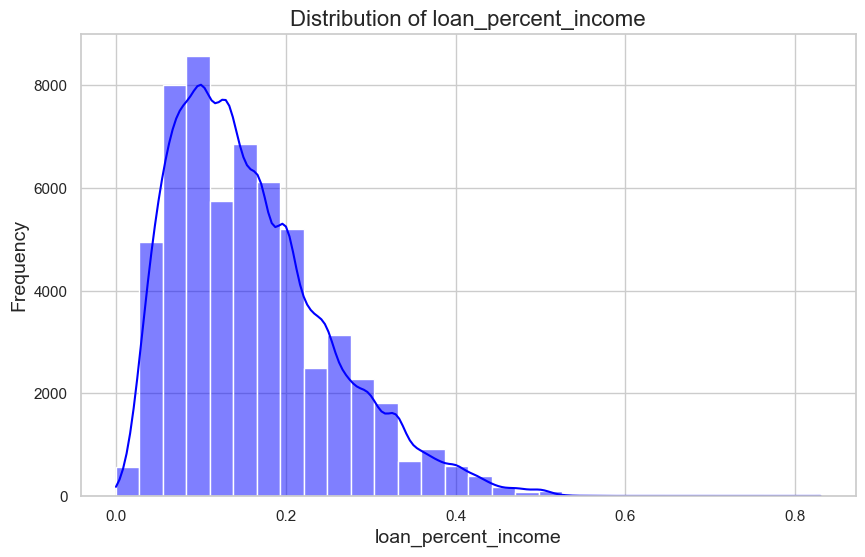

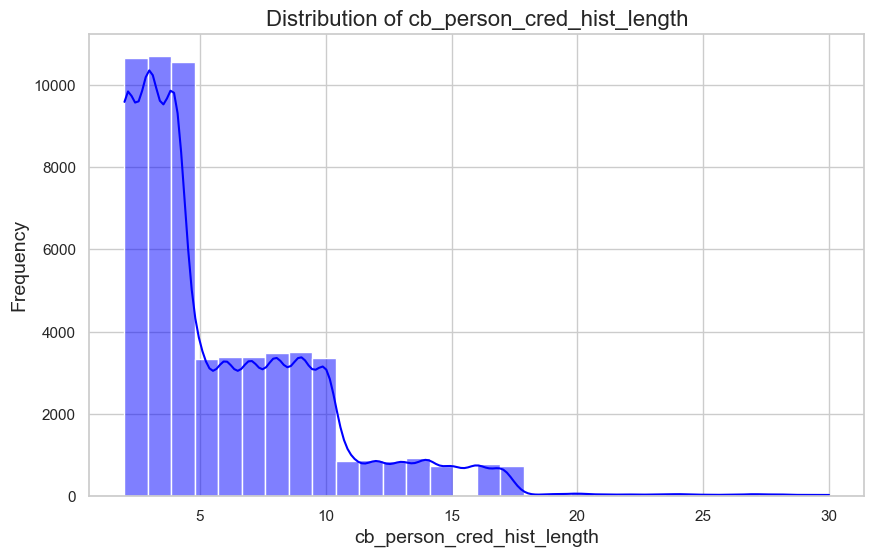

C:\Users\monas\AppData\Local\Temp\ipykernel_16076\2907263607.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="loan_status", data=df_train, palette="Set2")


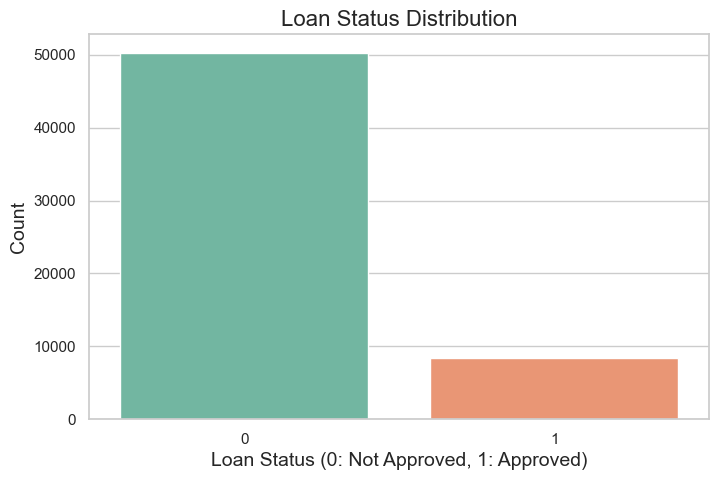

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Function to visualize distributions
def plot_distribution(data, column, title, bins=30):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], kde=True, bins=bins, color="blue")
    plt.title(title, fontsize=16)
    plt.xlabel(column, fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.show()

# Visualize numerical features
numerical_features = [
    "person_age",
    "person_income",
    "person_emp_length",
    "loan_amnt",
    "loan_int_rate",
    "loan_percent_income",
    "cb_person_cred_hist_length"
]

for feature in numerical_features:
    plot_distribution(df_train, feature, f"Distribution of {feature}")

# Visualize target class imbalance
plt.figure(figsize=(8, 5))
sns.countplot(x="loan_status", data=df_train, palette="Set2")
plt.title("Loan Status Distribution", fontsize=16)
plt.xlabel("Loan Status (0: Not Approved, 1: Approved)", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()


In [42]:
# print duplicates
print("Number of duplicates: ", df_train.duplicated().sum())
print("Unique values per column:")
df_train.nunique()

Number of duplicates:  0
Unique values per column:


person_age                      53
person_income                 2641
person_home_ownership            4
person_emp_length               36
loan_intent                      6
loan_grade                       7
loan_amnt                      545
loan_int_rate                  362
loan_percent_income             61
cb_person_default_on_file        2
cb_person_cred_hist_length      29
loan_status                      2
dtype: int64

In [44]:
same_values = df_train['loan_status'].eq(df_train['cb_person_default_on_file'])

print(same_values)

id
0        False
1        False
2        False
3        False
4        False
         ...  
58640    False
58641    False
58642    False
58643    False
58644    False
Length: 58645, dtype: bool


In [46]:
# check if Col1 and Col2 have opposite binary values
#mask = (df_train['loan_status']!= df_train['cb_person_default_on_file'])
mask = (df_train['loan_status']!=(df_train['cb_person_default_on_file']))
print(len(df_train[mask]))
print(mask)

58645
id
0        True
1        True
2        True
3        True
4        True
         ... 
58640    True
58641    True
58642    True
58643    True
58644    True
Length: 58645, dtype: bool


In a nutshell, loan_status = 1 means the applicant has a tendency to be defaulter. So in that case the committee should consider REJECTING the application.
0 - Loan approved and 1 - Loan not approved. So, in this competition we will be predicting the probability of the loan application getting rejected.
loan_status refers to whether the loan is (will be?) in a state of default, with 1=Default and 0=Non-default.

https://www.kaggle.com/competitions/playground-series-s4e10/discussion/536981

In [30]:
df_train['loan_status'].value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

In [31]:
df_train['person_home_ownership'].value_counts()

person_home_ownership
RENT        30594
MORTGAGE    24824
OWN          3138
OTHER          89
Name: count, dtype: int64

In [32]:
print('Training Data shape before set_index :', df_train.shape)
print('Testing Data shape before set_index:', df_test.shape)

Training Data shape before set_index : (58645, 12)
Testing Data shape before set_index: (39098, 11)


In [33]:
print('Training Data:', df_train.shape)
print('Testing Data:', df_test.shape)

Training Data: (58645, 12)
Testing Data: (39098, 11)


In [34]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [35]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39098 entries, 58645 to 97742
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  object 
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  object 
 5   loan_grade                  39098 non-null  object 
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  object 
 10  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 3.6+ MB


In [36]:
# Identify categorical and numerical features
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
numerical_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
                      'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']


C:\Users\monas\AppData\Local\Temp\ipykernel_16076\3387797622.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig=sns.distplot(df_train[column], color="g", label=collabel, norm_hist=True,
C:\Users\monas\AppData\Local\Temp\ipykernel_16076\3387797622.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig=sns.distplot

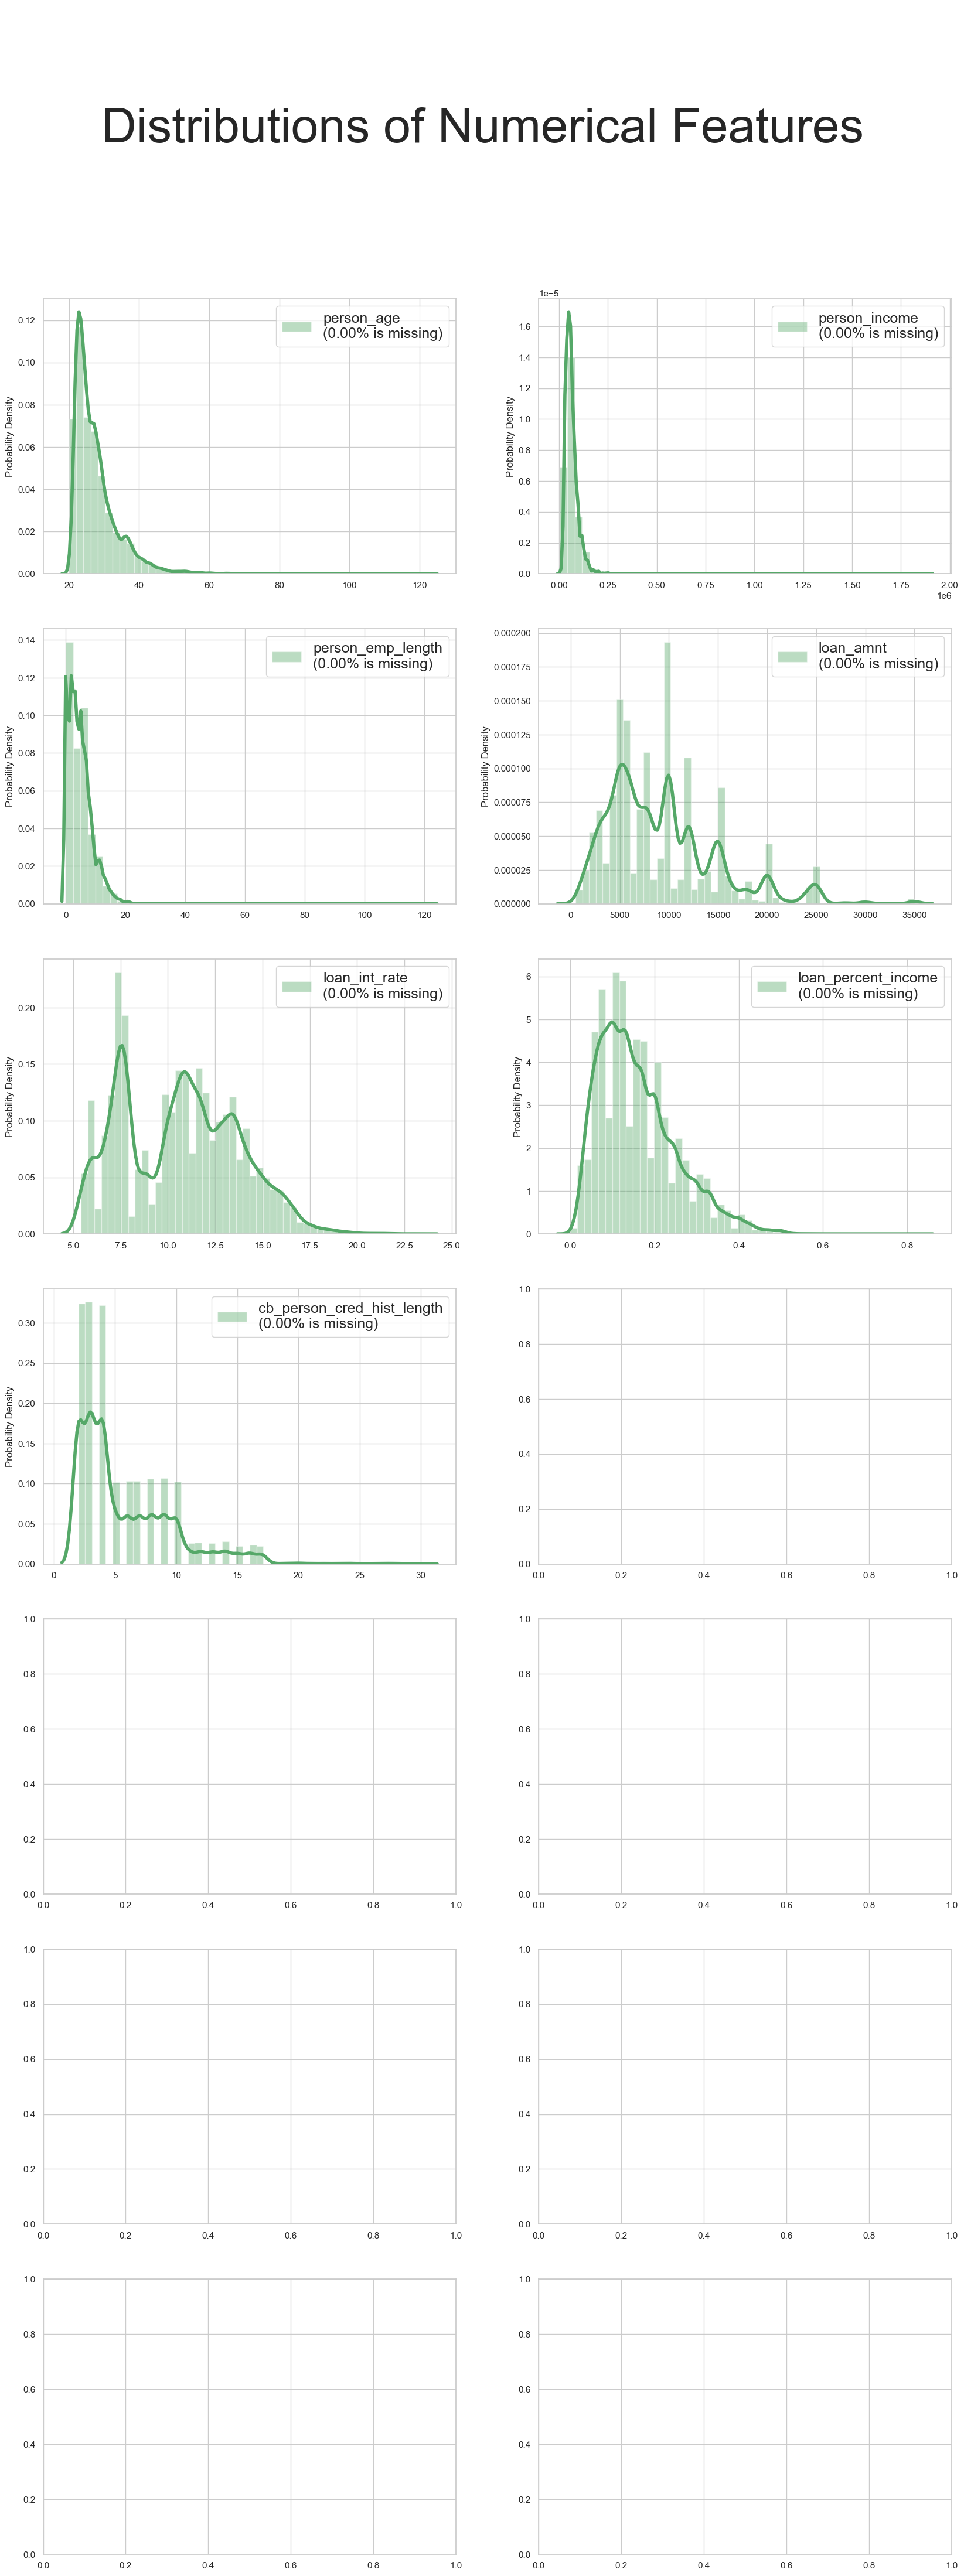

In [37]:
num_cols= numerical_features
n_rows, n_cols = (7,2)

figure, axes = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(20, 50))
figure.suptitle('\n\nDistributions of Numerical Features', fontsize=60)

for index, column in enumerate(num_cols):
    
    i,j = (index // n_cols), (index % n_cols)
    
    miss_perc="%.2f"%(100*(1-(df_train[column].dropna().shape[0])/df_train.shape[0]))
    
    collabel=column+"\n({}% is missing)".format(miss_perc)
    
    fig=sns.distplot(df_train[column], color="g", label=collabel, norm_hist=True,
    
    ax=axes[i,j], kde_kws={"lw":4})
    
    fig=fig.legend(loc='best', fontsize=18)
    
    axes[i,j].set_ylabel("Probability Density",fontsize='medium')
    
    axes[i,j].set_xlabel(None)

plt.show()

C:\Users\monas\AppData\Local\Temp\ipykernel_16076\240150764.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\monas\AppData\Local\Temp\ipykernel_16076\240150764.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2 * i + 1].set_xticklabels(axes[2 * i + 1].get_xticklabels(), fontsize=12, rotation=30)
C:\Users\monas\AppData\Local\Temp\ipykernel_16076\240150764.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\monas\AppData\Local\Temp\ipykernel_16076\240150764.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or usi

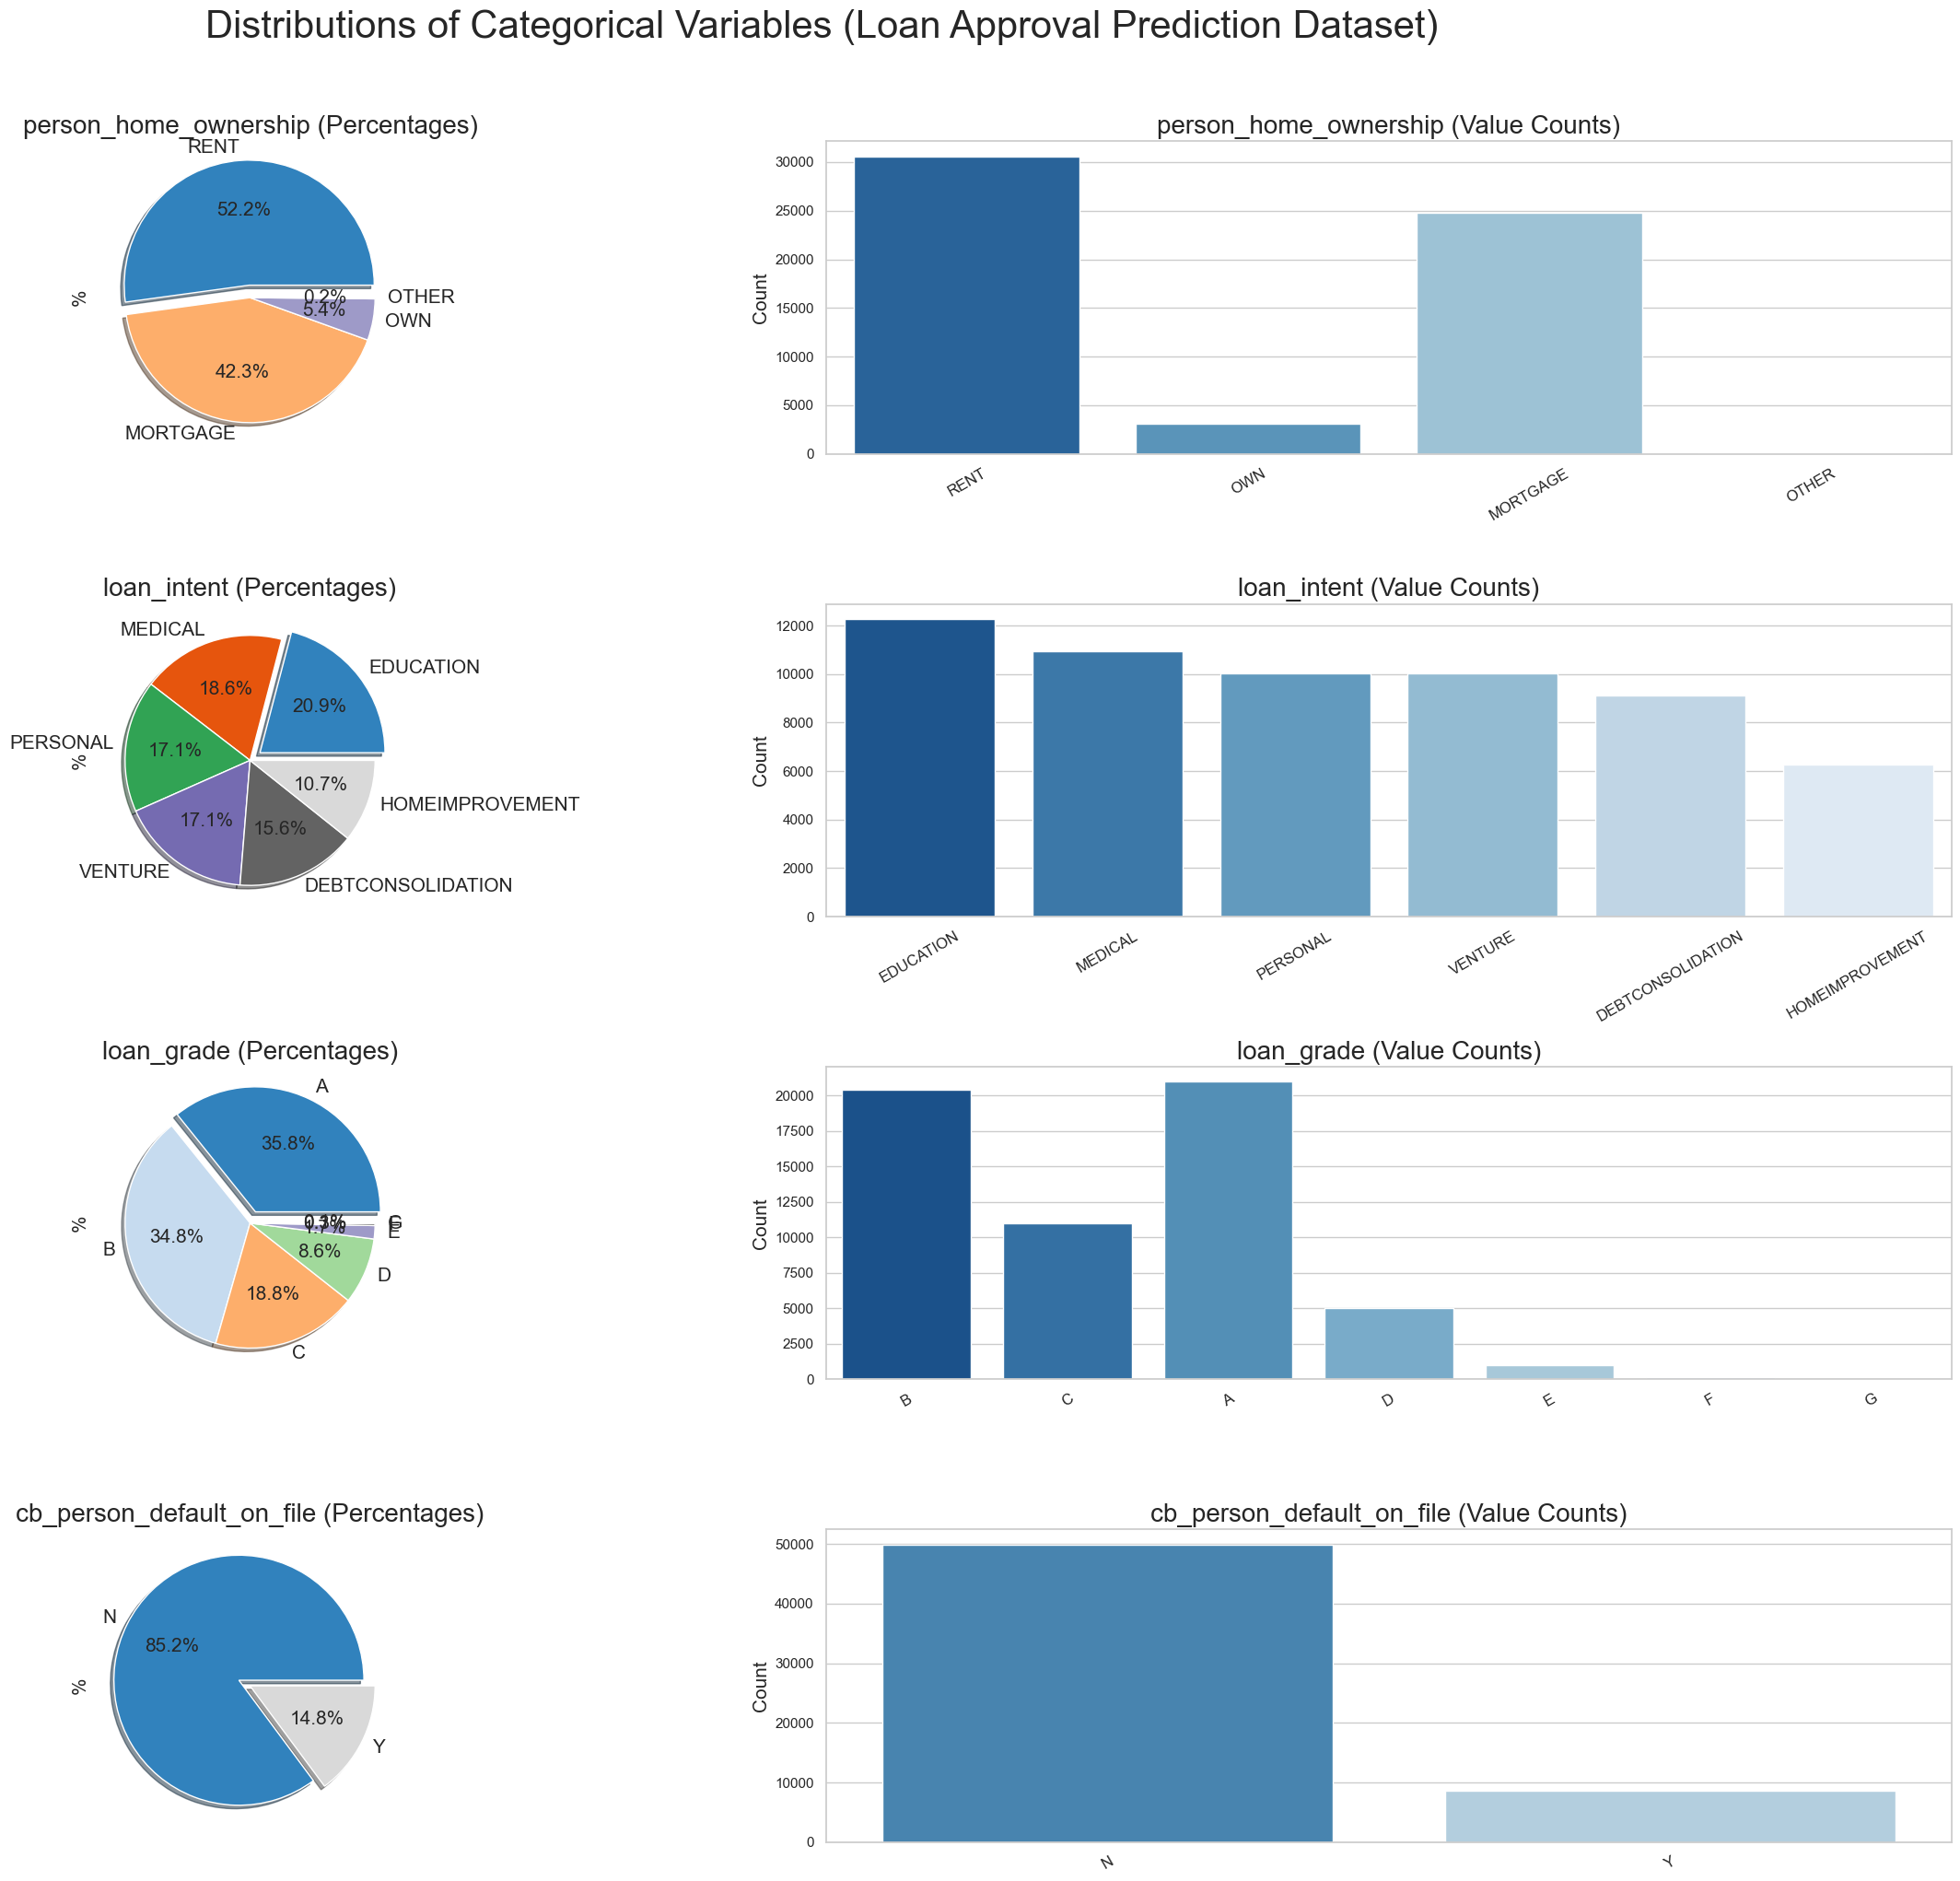

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define categorical columns
cat_cols = df_train.select_dtypes(include=['object']).columns.tolist()

# Calculate the number of rows required for the subplot grid
n_cols = 2  # Fixed as we want pie and bar chart side by side
n_rows = (2 * len(cat_cols) + n_cols - 1) // n_cols  # Total plots divided by columns, rounded up

# Create a figure with subplots
figure, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, 5 * n_rows))
figure.suptitle('Distributions of Categorical Variables (Loan Approval Prediction Dataset)', fontsize=30, y=1.02)
axes = axes.flatten()  # Flatten axes for easier iteration

# Iterate over each categorical column
for i, column in enumerate(cat_cols):
    # Pie chart
    df_train[column].value_counts().plot.pie(
        autopct='%1.1f%%',
        ax=axes[2 * i],  # Every categorical feature starts at an even index
        colormap="tab20c",
        fontsize=15,
        shadow=True,
        explode=[0.1] + [0] * (len(df_train[column].value_counts()) - 1),
    )
    axes[2 * i].set_ylabel('%', fontsize=15)
    axes[2 * i].set_title(f'{column} (Percentages)', fontsize=20)

    # Bar chart
    sns.countplot(
        x=column,
        data=df_train,
        palette='Blues_r',
        ax=axes[2 * i + 1],  # Bar chart follows immediately after the pie chart
    )
    axes[2 * i + 1].set_xlabel(None)
    axes[2 * i + 1].set_ylabel('Count', fontsize=15)
    axes[2 * i + 1].set_xticklabels(axes[2 * i + 1].get_xticklabels(), fontsize=12, rotation=30)
    axes[2 * i + 1].set_title(f'{column} (Value Counts)', fontsize=20)

# Remove unused subplot axes, if any
for j in range(2 * len(cat_cols), len(axes)):
    figure.delaxes(axes[j])

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


In [39]:
# Feature Engineering: Create new features
def feature_engineering_1(df):  #CB
# featrue engineering
    df['income_loan_ratio'] = df['person_income'] / df['loan_amnt']
    df['person_emp_length_to_person_age'] = df['person_emp_length'] / df['person_age']
    df['int_rate_income_ratio'] = df['loan_int_rate'] / df['person_income']
    df['cred_hist_age_ratio'] = df['cb_person_cred_hist_length'] / df['person_age']
    df["loan_percent_income_to_income"] = df["loan_percent_income"] / df["person_income"]
    df['person_age_to_person_income'] = df['person_age'] / df['person_income']
    df['loan_int_rate_to_loan_amnt'] = df['loan_int_rate'] / df['loan_amnt']
    return df

In [40]:
df_train = feature_engineering_1(df_train)
df_test = feature_engineering_1(df_test)

In [41]:
print('Training Data Shape afer feature eng:', df_train.shape)
print('Testing Data Shape after feature eng:', df_test.shape)

Training Data Shape afer feature eng: (58645, 19)
Testing Data Shape after feature eng: (39098, 18)


In [42]:
newly_added_features=['income_loan_ratio', 'person_emp_length_to_person_age', 'int_rate_income_ratio', 'cred_hist_age_ratio', 'loan_percent_income_to_income', 'person_age_to_person_income', 'loan_int_rate_to_loan_amnt']

In [43]:
# Update numerical features with new features
numerical_features.extend(['income_loan_ratio', 'person_emp_length_to_person_age', 'int_rate_income_ratio', 'cred_hist_age_ratio', 'loan_percent_income_to_income', 'person_age_to_person_income', 'loan_int_rate_to_loan_amnt'])


In [44]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   person_age                       58645 non-null  int64  
 1   person_income                    58645 non-null  int64  
 2   person_home_ownership            58645 non-null  object 
 3   person_emp_length                58645 non-null  float64
 4   loan_intent                      58645 non-null  object 
 5   loan_grade                       58645 non-null  object 
 6   loan_amnt                        58645 non-null  int64  
 7   loan_int_rate                    58645 non-null  float64
 8   loan_percent_income              58645 non-null  float64
 9   cb_person_default_on_file        58645 non-null  object 
 10  cb_person_cred_hist_length       58645 non-null  int64  
 11  loan_status                      58645 non-null  int64  
 12  income_loan_ratio      

In [45]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39098 entries, 58645 to 97742
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   person_age                       39098 non-null  int64  
 1   person_income                    39098 non-null  int64  
 2   person_home_ownership            39098 non-null  object 
 3   person_emp_length                39098 non-null  float64
 4   loan_intent                      39098 non-null  object 
 5   loan_grade                       39098 non-null  object 
 6   loan_amnt                        39098 non-null  int64  
 7   loan_int_rate                    39098 non-null  float64
 8   loan_percent_income              39098 non-null  float64
 9   cb_person_default_on_file        39098 non-null  object 
 10  cb_person_cred_hist_length       39098 non-null  int64  
 11  income_loan_ratio                39098 non-null  float64
 12  person_emp_length_t

# Select numerical columns
numerical_cols = df_train.select_dtypes(include=['int64', 'float64']).columns

# Summary statistics
print("Summary Statistics:\n")
print(df_train[numerical_cols].describe())

# Check for missing values
print("\nMissing Values:\n")
print(df_train[numerical_cols].isnull().sum())

# Visualize distributions of numerical columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot((len(numerical_cols) // 3) + 1, 3, i)
    sns.histplot(df_train[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

# Check for outliers using boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot((len(numerical_cols) // 3) + 1, 3, i)
    sns.boxplot(x=df_train[col], color='orange')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df_train[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Pairplot for relationships between features
sns.pairplot(df_train[numerical_cols].sample(min(len(df_train), 1000)))  # Sample for visualization if the dataset is large
plt.show()

# Insights from skewness
print("\nSkewness of Numerical Columns:\n")
print(df_train[numerical_cols].skew())

# Log-transform recommendation for skewed features
print("\nLog Transformation Recommendation (Skew > 1):")
for col in numerical_cols:
    if df_train[col].skew() > 1:
        print(f"- Consider log transformation for: {col}")

In [47]:
print('Training Data shape before Target Encoding :', df_train.shape)
print('Testing Data shape before Target Encoding:', df_test.shape)

Training Data shape before Target Encoding : (58645, 19)
Testing Data shape before Target Encoding: (39098, 18)


In [48]:
# Initialize Target Encoder
target_enc = ce.TargetEncoder(cols=categorical_features)


In [49]:
print('Training Data shape before Target Encoding :', df_train.shape)
print('Testing Data shape before Target Encoding:', df_test.shape)

Training Data shape before Target Encoding : (58645, 19)
Testing Data shape before Target Encoding: (39098, 18)


In [50]:
print('X shape before Optuna :', X.shape)
print('y shape before Optuna :', y.shape)

X shape before Optuna : (58645, 18)
y shape before Optuna : (58645,)


# Initialize TargetEncoder
target_enc = ce.TargetEncoder(cols=categorical_features)

# Stratified K-Fold for preserving class distribution
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize StandardScaler
scaler = StandardScaler()

# To store the transformed data
X_encoded_scaled = pd.DataFrame(index=X.index, columns=X.columns)

# Perform target encoding and scaling using cross-validation
for train_index, valid_index in skf.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # Fit the target encoder on training data
    target_enc.fit(X_train[categorical_features], y_train)
    
    # Transform both training and validation data
    X_train_encoded = X_train.copy()
    X_valid_encoded = X_valid.copy()
    X_train_encoded[categorical_features] = target_enc.transform(X_train[categorical_features])
    X_valid_encoded[categorical_features] = target_enc.transform(X_valid[categorical_features])
    
    # Fit the scaler on the numerical features of the training set
    scaler.fit(X_train_encoded[numerical_features])
    
    # Scale numerical features
    X_train_encoded[numerical_features] = scaler.transform(X_train_encoded[numerical_features])
    X_valid_encoded[numerical_features] = scaler.transform(X_valid_encoded[numerical_features])
    
    # Save encoded and scaled validation data
    X_encoded_scaled.loc[valid_index, categorical_features] = X_valid_encoded[categorical_features]
    X_encoded_scaled.loc[valid_index, numerical_features] = X_valid_encoded[numerical_features]

 
# Final fit on the entire dataset after cross-validation for consistency
target_enc.fit(X[categorical_features], y)
X_encoded_scaled[categorical_features] = target_enc.transform(X[categorical_features])
scaler.fit(X[numerical_features])
X_encoded_scaled[numerical_features] = scaler.transform(X[numerical_features])

# X_encoded_scaled now contains target-encoded categorical features and scaled numerical features


In [59]:
print("Hi")

Hi


In [76]:
# Separate features and target
X = df_train.drop(columns=["loan_status"])  # Features
y = df_train["loan_status"]  # Target

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify categorical and numerical features
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Perform target encoding for categorical features
target_encoder = TargetEncoder(cols=categorical_features)
X_train[categorical_features] = target_encoder.fit_transform(X_train[categorical_features], y_train)
X_valid[categorical_features] = target_encoder.transform(X_valid[categorical_features])

# Save the trained TargetEncoder object
with open('target_encoder.pkl', 'wb') as file:
    pickle.dump(target_encoder, file)

print("Target Encoder saved as 'target_encoder.pkl'")


# Scale numerical features using StandardScaler
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_valid[numerical_features] = scaler.transform(X_valid[numerical_features])

# Save the scaler object
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

print("Scaler saved as 'scaler.pkl'")

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Output the transformed datasets
print("Original X_train shape:", X_train.shape)
print("Resampled X_train shape:", X_train_resampled.shape)
print("Original y_train shape:", y_train.shape)
print("Resampled y_train shape:", y_train_resampled.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)


Target Encoder saved as 'target_encoder.pkl'
Scaler saved as 'scaler.pkl'
Original X_train shape: (46916, 18)
Resampled X_train shape: (80472, 18)
Original y_train shape: (46916,)
Resampled y_train shape: (80472,)
X_valid shape: (11729, 18)
y_valid shape: (11729,)


X_encoded_scaled

#df.drop(['loan_status'], axis=1).columns, inplace=True)
X_encoded_scaled.shape

###Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

rd_clf = RandomForestClassifier(criterion = 'entropy', max_depth = 11,  min_samples_leaf = 2, min_samples_split = 3, n_estimators = 130)
rd_clf.fit(X_train, y_train) #max_features = 'auto',

# accuracy score, confusion matrix and classification report of random forest
#print(X_test)
rd_clf_acc = accuracy_score(y_test, rd_clf.predict(X_test))

print(f"Training Accuracy of Random Forest Classifier is {accuracy_score(y_train, rd_clf.predict(X_train))}")
print(f"Test Accuracy of Random Forest Classifier is {rd_clf_acc} \n")

print(f"Confusion Matrix :- \n{confusion_matrix(y_test, rd_clf.predict(X_test))}\n")
print(f"Classification Report :- \n {classification_report(y_test, rd_clf.predict(X_test))}")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Initialize the Random Forest Classifier with given hyperparameters
rd_clf = RandomForestClassifier(
    criterion='entropy', 
    max_depth=11,  
    min_samples_leaf=2, 
    min_samples_split=3, 
    n_estimators=130,
    random_state=42
)

# Train the Random Forest Classifier
rd_clf.fit(X_train, y_train)

# Predict probabilities for the validation set
y_valid_probs = rd_clf.predict_proba(X_valid)[:, 1]  # Probability for the positive class

# Calculate ROC AUC score for validation set
roc_auc = roc_auc_score(y_valid, y_valid_probs)

# Print training accuracy for comparison (optional)
train_acc = rd_clf.score(X_train, y_train)
print(f"Training Accuracy of Random Forest Classifier is {train_acc:.4f}")

# Print ROC AUC score
print(f"ROC AUC Score on Validation Set is {roc_auc:.4f}\n")

# Generate predictions for confusion matrix and classification report
y_valid_preds = rd_clf.predict(X_valid)

# Print confusion matrix
print(f"Confusion Matrix:\n{confusion_matrix(y_valid, y_valid_preds)}\n")

# Print classification report
print(f"Classification Report:\n{classification_report(y_valid, y_valid_preds)}")


In [ ]:
# view the feature scores

feature_scores = pd.Series(rd_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

In [ ]:
# Creating a seaborn bar plot

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, color='turquoise', label='big') # , data=kd_df)
ax.set_title("Visualize feature scores of the features", fontsize=80)
ax.set_yticklabels(feature_scores.index, fontsize=40)
ax.set_xlabel("Feature importance score", fontsize=60)
ax.set_xticklabels(round(feature_scores*100,2), fontsize=40)
ax.set_ylabel("Features", fontsize=60)
plt.show()

In [ ]:
type(feature_scores)

In [ ]:
newly_added_features

In [ ]:
df_features = feature_scores.reset_index().rename(columns={"index":"features"})		

In [ ]:
df_features

In [ ]:
loan_grade, loan_percent_income, person_home_ownership, loan_int_rate, loan_intent, person_income, person_emp_length, loan_amount, 

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DCT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('XGB', XGBClassifier()))
models.append(('RF', RandomForestClassifier(n_estimators=200)))
models.append(('CB', CatBoostClassifier(verbose= False)))
models.append(('LGBM', LGBMClassifier(verbosity= -1)))
models.append(('EXTREE', ExtraTreesClassifier(verbose= False)))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'roc_auc' #'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=None)
    cv_results = model_selection.cross_val_score(model, X_encoded_scaled, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# prepare configuration for cross validation test harness
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DCT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('XGB', XGBClassifier()))
models.append(('RF', RandomForestClassifier(n_estimators=200)))
models.append(('CB', CatBoostClassifier(verbose= False)))
models.append(('LGBM', LGBMClassifier(verbosity= -1)))
models.append(('EXTREE', ExtraTreesClassifier(verbose= False)))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'roc_auc'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=None)
    cv_results = model_selection.cross_val_score(model, X_encoded_scaled, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
# Prepare arrays for out-of-fold predictions
oof_preds = np.zeros(X.shape[0])
test_preds = np.zeros(df_test.shape[0])

In [ ]:
# Define objective function for Optuna
def objective(trial):
    aucs = []
    for train_index, valid_index in skf.split(X, y):
        X_train_fold, X_valid_fold = X.iloc[train_index], X.iloc[valid_index]
        y_train_fold, y_valid_fold = y.iloc[train_index], y.iloc[valid_index]

        # Target Encoding
        X_train_fold = target_enc.fit_transform(X_train_fold, y_train_fold)
        X_valid_fold = target_enc.transform(X_valid_fold)
        X_test_enc = target_enc.transform(df_test)

        # Handle class imbalance with SMOTE
        sm = SMOTE(random_state=42)
        X_resampled, y_resampled = sm.fit_resample(X_train_fold, y_train_fold)

        #X_resampled, y_resampled = X_train_fold, y_train_fold
        
        # Scale numerical features
        scaler = StandardScaler()
        X_resampled[numerical_features] = scaler.fit_transform(X_resampled[numerical_features])
        X_valid_fold[numerical_features] = scaler.transform(X_valid_fold[numerical_features])
        X_test_enc[numerical_features] = scaler.transform(X_test_enc[numerical_features])

        # Define LightGBM parameters using new suggest methods
        param = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'subsample': trial.suggest_float('subsample', 0.4, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
            'random_state': 42,
            'verbosity': -1,
            'n_jobs': -1,
            #'device': 'cuda',
        }

        lgb_train = lgb.Dataset(X_resampled, y_resampled)
        lgb_valid = lgb.Dataset(X_valid_fold, y_valid_fold, reference=lgb_train)

        # Use early_stopping and log_evaluation as callbacks
        pruning_callback = LightGBMPruningCallback(trial, 'auc')
        early_stopping_callback = lgb.early_stopping(stopping_rounds=100, verbose=False)
        log_eval_callback = lgb.log_evaluation(period=0)  # Suppress logging during optimization

        callbacks = [pruning_callback, early_stopping_callback, log_eval_callback]

        # Include valid_names to ensure the validation dataset is named 'valid_0'
        gbm = lgb.train(
            param,
            lgb_train,
            num_boost_round=10000,
            valid_sets=[lgb_train, lgb_valid],
            valid_names=['training', 'valid_0'],  # Specify names here
            callbacks=callbacks
        )

        y_valid_pred = gbm.predict(X_valid_fold, num_iteration=gbm.best_iteration)
        auc = roc_auc_score(y_valid_fold, y_valid_pred)
        aucs.append(auc)

    return np.mean(aucs)

In [ ]:
# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='maximize', study_name='lgbm_classifier')
study.optimize(objective, n_trials=50)

In [ ]:
best_params = study.best_params
print('Best Hyperparameters:')
print(best_params)

Best Hyperparameters:
{'learning_rate': 0.07494066339794482, 'num_leaves': 36, 'max_depth': 4, 'min_child_samples': 80, 'subsample': 0.47232380658590173, 'colsample_bytree': 0.561711350752377, 'reg_alpha': 0.3026778531642185, 'reg_lambda': 0.7583892699023145}

In [ ]:
# Retrieve the best parameters
best_params = study.best_params
best_params['objective'] = 'binary'
best_params['metric'] = 'auc'
best_params['boosting_type'] = 'gbdt'
best_params['random_state'] = 42
best_params['verbosity'] = -1
best_params['n_jobs'] = -1

In [ ]:
print('Best Hyperparameters:')
print(best_params)


Best Hyperparameters:
{'learning_rate': 0.07494066339794482, 'num_leaves': 36, 'max_depth': 4, 'min_child_samples': 80, 'subsample': 0.47232380658590173, 'colsample_bytree': 0.561711350752377, 'reg_alpha': 0.3026778531642185, 'reg_lambda': 0.7583892699023145, 'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'random_state': 42, 'verbosity': -1, 'n_jobs': -1}

In [ ]:
# Train the model with best hyperparameters and make predictions
for fold, (train_index, valid_index) in enumerate(skf.split(X, y)):
    print(f'Fold {fold + 1}')
    X_train_fold, X_valid_fold = X.iloc[train_index], X.iloc[valid_index]
    y_train_fold, y_valid_fold = y.iloc[train_index], y.iloc[valid_index]

    # Target Encoding
    X_train_fold = target_enc.fit_transform(X_train_fold, y_train_fold)
    X_valid_fold = target_enc.transform(X_valid_fold)
    X_test_enc = target_enc.transform(df_test)

    # Handle class imbalance with SMOTE
    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X_train_fold, y_train_fold)

    #X_resampled, y_resampled = X_train_fold, y_train_fold
    
    # Scale numerical features
    scaler = StandardScaler()
    X_resampled[numerical_features] = scaler.fit_transform(X_resampled[numerical_features])
    X_valid_fold[numerical_features] = scaler.transform(X_valid_fold[numerical_features])
    X_test_enc[numerical_features] = scaler.transform(X_test_enc[numerical_features])

    lgb_train = lgb.Dataset(X_resampled, y_resampled)
    lgb_valid = lgb.Dataset(X_valid_fold, y_valid_fold, reference=lgb_train)

    # Use early_stopping and log_evaluation as callbacks
    early_stopping_callback = lgb.early_stopping(stopping_rounds=100, verbose=False)
    log_eval_callback = lgb.log_evaluation(period=100)

    callbacks = [early_stopping_callback, log_eval_callback]

    # Include valid_names here as well
    gbm = lgb.train(
        best_params,
        lgb_train,
        num_boost_round=10000,
        valid_sets=[lgb_train, lgb_valid],
        valid_names=['training', 'valid_0'],
        callbacks=callbacks
    )

    # Predict on validation set
    y_valid_pred = gbm.predict(X_valid_fold, num_iteration=gbm.best_iteration)
    oof_preds[valid_index] = y_valid_pred

    # Predict on test set
    test_fold_pred = gbm.predict(X_test_enc, num_iteration=gbm.best_iteration)
    test_preds += test_fold_pred / skf.n_splits

In [ ]:
# Evaluate the overall model performance
roc_auc = roc_auc_score(y, oof_preds)
print(f'Overall ROC-AUC Score: {roc_auc}')
#Overall ROC-AUC Score: 0.9578482117185253

In [ ]:
# Prepare the submission file
submission_df = pd.DataFrame({'id': df_test.index, 'loan_status': test_preds})
submission_file_path = 'loan_approval_submission_Mona_4.csv'
submission_df.to_csv(submission_file_path, index=False)

In [ ]:
# Display the first few rows of the submission file
print(submission_df.head())